## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use ('ggplot')
import numpy as np
from sklearn import linear_model
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
#to display multiple outputs from one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Reading in Data

In [3]:
df1=pd.read_csv(r'Trading Analytics.csv')

#to clean all of the column names
df1.columns = df1.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '').str.replace('&', '').str.replace('.', '').str.replace('?', '').str.replace('$', '').str.replace('%', '').str.replace('*', '').str.replace('=', '').str.replace('/', '').str.replace(':', '').str.replace('_', '').str.replace('-', '').str.replace('+', '')

# to remove columns
drop_cols = ['unnamed40','unnamed41', 'unnamed42', 'unnamed43', 'unnamed44', 'unnamed45', 'unnamed46','unnamed47','unnamed48', 'unnamed49', 'unnamed50','qualify','volume',
             'tradetime','eventtime','offer','bid','buyer','seller','buyerid','sellerid','rpertr','upertrq','unrealtot','1sthour','lasthour','1sthrusrtotvol','lasthusrtotvol',
             'range','p2p11','lnp2p1','volatstdevofln']
df1 = df1.drop(drop_cols, axis=1)

#to fix col that start with 1
df1.columns = df1.columns.str.replace('1', 'fir')

#to split ido into desk number and trader number
    # note trader number no longer has the C in the front
df1[['desk','trader']] = df1.ido.str.split("C",n=1,expand=True)

#to change the percentages into floats
df1['useroftotalvolu'] = df1['useroftotalvolu'].str.rstrip('%').astype('float') / 100.0
df1['firsthrusrfirsthrtot'] = df1['firsthrusrfirsthrtot'].str.rstrip('%').astype('float') / 100.0
df1['lasthusrlasthrtot'] = df1['lasthusrlasthrtot'].str.replace('#DIV/0!', 'NaN')
df1['lasthusrlasthrtot'] = df1['lasthusrlasthrtot'].str.rstrip('%').astype('float') / 100.0

df1['desk'] = df1['desk'].str.replace('S 10', 'S10').str.replace('TralS9', 'S9').str.replace('S37b08T', 'S3').str.replace('S3 ', 'S3')

df1.describe(include='all')


,ido,price,realizedtot,unrealq,uservolu,useroftotalvolu,totalvolu,tradecount,firsthourvolu,firsthouruservolu,...,firsthrusrfirsthrtot,lasthusrlasthrtot,vwap,pricev,net,userbuy,usersell,uservoltradedbuysell,desk,trader
count,411,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,...,411.000000,407.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411,410
unique,396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,268
top,S10C715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S9,10b1
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,5
mean,NaN,20.808273,3278.796627,-164.790754,953.535280,0.263998,3274.695864,49.150852,1236.871046,206.776156,...,0.143124,0.129661,20.280122,390.257908,-114.771263,394.372263,559.163017,953.535280,NaN,NaN
std,NaN,0.314029,6936.595084,339.833403,890.695766,0.174540,764.241727,39.194719,577.621321,212.855117,...,0.093477,0.104782,0.066117,279.854359,288.169334,458.216085,494.419724,890.695766,NaN,NaN
min,NaN,19.500000,-58791.400130,-2349.000000,0.000000,0.000000,498.000000,0.000000,192.000000,0.000000,...,0.000000,0.000000,19.983490,20.500000,-1861.500000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,20.600000,32.550039,-271.000000,378.500000,0.135219,2860.000000,24.000000,838.000000,70.000000,...,0.077256,0.046825,20.251380,206.000000,-165.799948,140.000000,210.500000,378.500000,NaN,NaN
50%,NaN,20.900000,1543.399964,-76.000000,692.000000,0.227183,3123.000000,40.000000,1046.000000,144.000000,...,0.127599,0.102161,20.286339,370.800000,-45.699832,255.000000,416.000000,692.000000,NaN,NaN
75%,NaN,21.000000,5414.400053,0.000000,1190.000000,0.354173,3504.500000,60.500000,1441.000000,267.000000,...,0.196387,0.191297,20.322672,476.100000,5.650149,457.500000,732.000000,1190.000000,NaN,NaN


In [4]:
df2 = pd.read_excel('Survey_clean.xlsx')

#to clean the column names
df2.columns = df2.columns.str.strip().str.replace(".","").str.replace("Unnamed: 1","Gender")

#to change IDo to ido so it matches the id column in df1 to make it easier to combine the dataframes; 
#I later learned that these could be combined without the column names being the same
df2.columns = df2.columns.str.replace('IDo', 'ido')

#to remove the row with the questions for analysis and to choose the desired questions
df2 = df2.iloc[1:]
df2 = df2[["ido","Gender","Q2","Q9","Q12","Q14","Q15","Q30"]]

#to split IDo into seperate columns for desk and trader
df2[['desk','trader']] = df2.ido.str.split("C",n=1,expand=True)

#to fix some of the desk names
df2['desk'] = df2['desk'].str.replace('S 10', 'S10').str.replace('S37b08T', 'S3').str.replace('S3 ', 'S3')

#to change the responses into a likert scale
df2['Q2'] = df2['Q2'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df2['Q9'] = df2['Q9'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df2['Q12'] = df2['Q12'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df2['Q14'] = df2['Q14'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df2['Q15'] = df2['Q15'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df2['Q30'] = df2['Q30'].str.replace('Yes', 'Y').str.replace('No', 'N')

#df2

df2.describe(include='all')

,ido,Gender,Q2,Q9,Q12,Q14,Q15,Q30,desk,trader
count,363,363,363,363,363,363,363,363,363,362
unique,349,2,5,5,5,5,5,2,10,235
top,S2C308T,M,2,2,2,2,2,N,S6,10a1
freq,2,193,110,167,203,179,212,289,52,5


### Creating one dataframe with both the trading analytics data and the survey data
### Data was matched by the IDo column

In [5]:
#combined along the IDo column; how as inner only inclued the rows that are common in both dataframes
data = pd.merge(df1, df2, on='ido', how='inner')

#removing the duplicate entries of desk and trader
data = data.drop(columns=['desk_x'])
data = data.drop(columns=['trader_x'])
#renaming the remaining desk and trader columns
data = data.rename(columns={'desk_y':'desk','trader_y':'trader'})

data

,ido,price,realizedtot,unrealq,uservolu,useroftotalvolu,totalvolu,tradecount,firsthourvolu,firsthouruservolu,...,uservoltradedbuysell,Gender,Q2,Q9,Q12,Q14,Q15,Q30,desk,trader
0,S9C2015,21.000000,-435.100000,20,310,0.092814,3340,21,1546,168,...,310,M,3,2,4,4,2,N,S9,2015
1,S9C1915,21.000000,1109.200000,-53,165,0.060395,2732,18,788,0,...,165,M,3,2,4,4,2,N,S9,1915
2,S9C1615,21.000000,17.799998,0,164,0.059399,2761,12,848,32,...,164,M,1,3,3,3,3,Y,S9,1615
3,S9C15TS,21.000000,-1245.700090,58,882,0.251139,3512,58,1022,130,...,882,F,3,2,2,2,2,N,S9,15TS
4,S9C1515,21.000000,-20.000000,0,200,0.071608,2793,16,828,20,...,200,M,3,2,2,2,2,N,S9,1515
5,S9C1415,21.000000,1535.500000,-75,135,0.042776,3156,11,828,20,...,135,F,4,2,2,4,1,N,S9,1415
6,S9C1215,20.900000,3238.200094,-162,730,0.231893,3148,39,788,5,...,730,M,5,2,2,4,1,N,S9,1215
7,S9C115T,21.000000,1249.000050,-60,60,0.021598,2778,2,788,0,...,60,F,2,1,1,3,2,N,S9,115T
8,S9C1115,20.600000,102.200025,-7,333,0.116393,2861,21,896,59,...,333,M,4,1,2,5,2,N,S9,1115
9,S9C1015,20.700000,1121.000000,-55,115,0.040154,2864,7,838,25,...,115,M,2,5,2,1,1,Y,S9,1015


In [7]:
# checking df1 data frame

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 22 columns):
ido                     411 non-null object
price                   411 non-null float64
realizedtot             411 non-null float64
unrealq                 411 non-null int64
uservolu                411 non-null int64
useroftotalvolu         411 non-null float64
totalvolu               411 non-null int64
tradecount              411 non-null int64
firsthourvolu           411 non-null int64
firsthouruservolu       411 non-null int64
lasthourvolu            411 non-null int64
lasthouruservolu        411 non-null int64
firsthrusrfirsthrtot    411 non-null float64
lasthusrlasthrtot       407 non-null float64
vwap                    411 non-null float64
pricev                  411 non-null float64
net                     411 non-null float64
userbuy                 411 non-null int64
usersell                411 non-null int64
uservoltradedbuysell    411 non-null int64
desk              

In [8]:
# checking df2 data frame

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 1 to 363
Data columns (total 10 columns):
ido       363 non-null object
Gender    363 non-null object
Q2        363 non-null object
Q9        363 non-null object
Q12       363 non-null object
Q14       363 non-null object
Q15       363 non-null object
Q30       363 non-null object
desk      363 non-null object
trader    362 non-null object
dtypes: object(10)
memory usage: 28.4+ KB


In [9]:
# checking combined df1 and df2 data frame

data.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 29 columns):
ido                     392 non-null object
price                   392 non-null float64
realizedtot             392 non-null float64
unrealq                 392 non-null int64
uservolu                392 non-null int64
useroftotalvolu         392 non-null float64
totalvolu               392 non-null int64
tradecount              392 non-null int64
firsthourvolu           392 non-null int64
firsthouruservolu       392 non-null int64
lasthourvolu            392 non-null int64
lasthouruservolu        392 non-null int64
firsthrusrfirsthrtot    392 non-null float64
lasthusrlasthrtot       388 non-null float64
vwap                    392 non-null float64
pricev                  392 non-null float64
net                     392 non-null float64
userbuy                 392 non-null int64
usersell                392 non-null int64
uservoltradedbuysell    392 non-null int64
Gender            

In [10]:
# data.describe with increased width to fit all columns

with pd.option_context('display.max_columns', 40):
    data.describe(include="all")

,ido,price,realizedtot,unrealq,uservolu,useroftotalvolu,totalvolu,tradecount,firsthourvolu,firsthouruservolu,lasthourvolu,lasthouruservolu,firsthrusrfirsthrtot,lasthusrlasthrtot,vwap,pricev,net,userbuy,usersell,uservoltradedbuysell,Gender,Q2,Q9,Q12,Q14,Q15,Q30,desk,trader
count,392,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,388.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392,392,392,392,392,392,392,392,391
unique,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,5,5,5,5,2,10,235
top,S2C908T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,2,2,2,2,2,N,S6,314T
freq,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212,119,184,224,195,231,313,54,6
mean,NaN,20.812500,3289.538810,-165.420918,982.201531,0.270672,3284.155612,50.306122,1232.984694,207.318878,2534.892857,383.201531,0.143827,0.133455,20.279862,386.665052,-119.399717,408.390306,573.811224,982.201531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.320361,6835.969267,334.226387,912.381383,0.177993,789.655170,39.934258,558.884310,211.047752,748.578991,443.002812,0.094727,0.106844,0.066371,284.307656,294.348785,471.533959,499.729185,912.381383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,19.500000,-58791.400130,-2349.000000,18.000000,0.006662,498.000000,2.000000,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.983490,20.500000,-1861.500000,0.000000,9.000000,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,20.600000,32.725034,-286.000000,369.250000,0.133912,2862.750000,25.000000,835.500000,69.000000,2170.000000,102.750000,0.075431,0.049843,20.251412,189.675000,-178.124978,135.000000,200.000000,369.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,20.900000,1696.400075,-87.000000,728.000000,0.239285,3132.000000,40.500000,1042.000000,145.500000,2450.000000,240.500000,0.128167,0.107688,20.287872,357.000000,-47.850049,267.500000,447.000000,728.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,21.000000,5561.500012,0.000000,1210.750000,0.364490,3504.250000,62.250000,1459.500000,271.750000,2758.000000,498.500000,0.204022,0.200556,20.322294,473.800000,6.600223,476.250000,750.000000,1210.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Correlations

In [11]:
data.corr()

,price,realizedtot,unrealq,uservolu,useroftotalvolu,totalvolu,tradecount,firsthourvolu,firsthouruservolu,lasthourvolu,lasthouruservolu,firsthrusrfirsthrtot,lasthusrlasthrtot,vwap,pricev,net,userbuy,usersell,uservoltradedbuysell
price,1.000000,-0.322234,0.317269,0.056225,-0.046039,0.190486,0.100875,-0.006983,-0.055045,0.153718,0.017955,-0.076693,-0.080288,0.392976,-0.053455,-0.063706,0.166837,-0.054771,0.056225
realizedtot,-0.322234,1.000000,-0.999432,0.065619,0.220987,-0.018617,0.066973,-0.096819,0.018757,0.039508,0.056754,0.165148,0.241995,-0.618644,0.087599,-0.437306,-0.290718,0.394119,0.065619
unrealq,0.317269,-0.999432,1.000000,-0.089804,-0.240523,-0.005599,-0.091705,0.084392,-0.032100,-0.058435,-0.077997,-0.175279,-0.259176,0.623107,-0.090847,0.453853,0.267522,-0.416387,-0.089804
uservolu,0.056225,0.065619,-0.089804,1.000000,0.918119,0.871983,0.939126,0.560105,0.678354,0.707297,0.882110,0.601184,0.812852,-0.198003,0.149524,-0.349539,0.935634,0.942907,1.000000
useroftotalvolu,-0.046039,0.220987,-0.240523,0.918119,1.000000,0.665302,0.844378,0.474861,0.649090,0.527511,0.803315,0.702403,0.896458,-0.389410,0.138320,-0.300966,0.803002,0.918561,0.918119
totalvolu,0.190486,-0.018617,-0.005599,0.871983,0.665302,1.000000,0.860566,0.649590,0.635523,0.776783,0.736602,0.431507,0.588415,0.032516,0.144827,-0.437733,0.841625,0.797885,0.871983
tradecount,0.100875,0.066973,-0.091705,0.939126,0.844378,0.860566,1.000000,0.527045,0.614736,0.689227,0.812628,0.537718,0.734109,-0.164624,0.104665,-0.444447,0.876067,0.887972,0.939126
firsthourvolu,-0.006983,-0.096819,0.084392,0.560105,0.474861,0.649590,0.527045,1.000000,0.879348,0.197288,0.313909,0.567789,0.322549,-0.124610,0.113630,-0.285641,0.571788,0.483085,0.560105
firsthouruservolu,-0.055045,0.018757,-0.032100,0.678354,0.649090,0.635523,0.614736,0.879348,1.000000,0.272707,0.416814,0.840295,0.452582,-0.249577,0.140481,-0.295986,0.644904,0.629987,0.678354
lasthourvolu,0.153718,0.039508,-0.058435,0.707297,0.527511,0.776783,0.689227,0.197288,0.272707,1.000000,0.831839,0.223220,0.602636,0.162846,0.117042,-0.255134,0.663573,0.665216,0.707297


### Heatmap

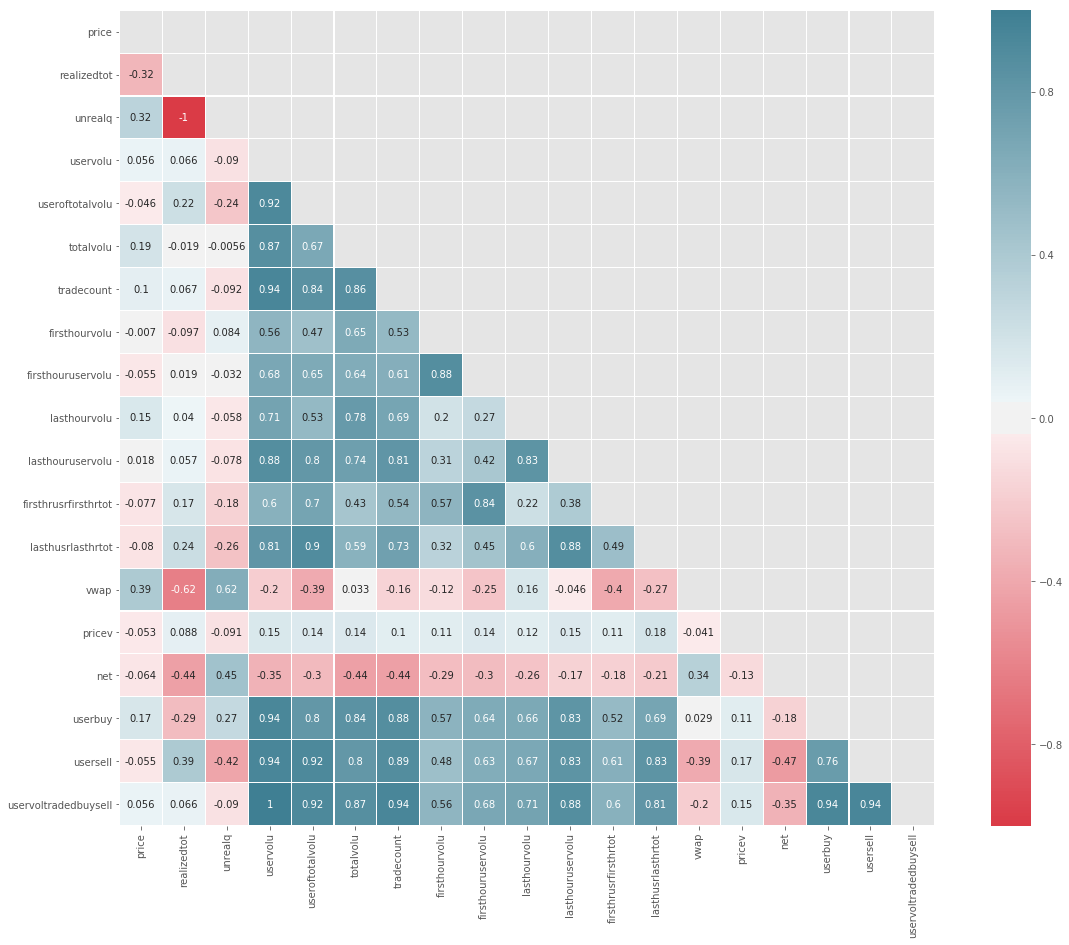

In [12]:
corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.1, annot=True);


# net does not seem to be closely correlated, postitively or negatively, to any other variables
# realizedtot and unrealq have a nearly perfect negative correlation

# uservoltradebuysell and uservolu - perfect positive correlation

### Clustermaps

##### Making new Data Frame (cdata)

In [89]:
# dropping ido, desk, trader, and lasthusrlasthrtot

cdata=data.drop('ido', axis=1)
cdata.Gender = cdata.Gender.str.replace("F",'0').str.replace("M", '1')
cdata.Q30 = cdata.Q30.str.replace("Y",'1').str.replace("N", '0')
cdata=cdata.drop('desk', axis=1)
cdata=cdata.drop('trader', axis=1)
cdata=cdata.drop('lasthusrlasthrtot', axis=1)


# changing some column  values to integers

cdata['Gender']=cdata['Gender'].astype("int")
cdata['Q2']=cdata['Q2'].astype("int")
cdata['Q9']=cdata['Q9'].astype("int")
cdata['Q12']=cdata['Q12'].astype("int")
cdata['Q14']=cdata['Q14'].astype("int")
cdata['Q15']=cdata['Q15'].astype("int")
cdata['Q30']=cdata['Q30'].astype("int")

In [90]:
#cdata=cdata.drop('Gender', axis=1)
#cdata=cdata.drop('Q2', axis=1)
#cdata=cdata.drop('Q9', axis=1)
#cdata=cdata.drop('Q12', axis=1)
#cdata=cdata.drop('Q14', axis=1)
#cdata=cdata.drop('Q15', axis=1)
#cdata=cdata.drop('Q30', axis=1)

In [91]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 25 columns):
price                   392 non-null float64
realizedtot             392 non-null float64
unrealq                 392 non-null int64
uservolu                392 non-null int64
useroftotalvolu         392 non-null float64
totalvolu               392 non-null int64
tradecount              392 non-null int64
firsthourvolu           392 non-null int64
firsthouruservolu       392 non-null int64
lasthourvolu            392 non-null int64
lasthouruservolu        392 non-null int64
firsthrusrfirsthrtot    392 non-null float64
vwap                    392 non-null float64
pricev                  392 non-null float64
net                     392 non-null float64
userbuy                 392 non-null int64
usersell                392 non-null int64
uservoltradedbuysell    392 non-null int64
Gender                  392 non-null int32
Q2                      392 non-null int32
Q9                   

In [92]:
# checking data frame

print(cdata.columns)

cdata.info();

with pd.option_context('display.max_columns', 40):
    cdata.describe(include="all")

Index(['price', 'realizedtot', 'unrealq', 'uservolu', 'useroftotalvolu',
       'totalvolu', 'tradecount', 'firsthourvolu', 'firsthouruservolu',
       'lasthourvolu', 'lasthouruservolu', 'firsthrusrfirsthrtot', 'vwap',
       'pricev', 'net', 'userbuy', 'usersell', 'uservoltradedbuysell',
       'Gender', 'Q2', 'Q9', 'Q12', 'Q14', 'Q15', 'Q30'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 25 columns):
price                   392 non-null float64
realizedtot             392 non-null float64
unrealq                 392 non-null int64
uservolu                392 non-null int64
useroftotalvolu         392 non-null float64
totalvolu               392 non-null int64
tradecount              392 non-null int64
firsthourvolu           392 non-null int64
firsthouruservolu       392 non-null int64
lasthourvolu            392 non-null int64
lasthouruservolu        392 non-null int64
firsthrusrfirsthrtot    392 non-null float64


,price,realizedtot,unrealq,uservolu,useroftotalvolu,totalvolu,tradecount,firsthourvolu,firsthouruservolu,lasthourvolu,lasthouruservolu,firsthrusrfirsthrtot,vwap,pricev,net,userbuy,usersell,uservoltradedbuysell,Gender,Q2,Q9,Q12,Q14,Q15,Q30
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,20.812500,3289.538810,-165.420918,982.201531,0.270672,3284.155612,50.306122,1232.984694,207.318878,2534.892857,383.201531,0.143827,20.279862,386.665052,-119.399717,408.390306,573.811224,982.201531,0.540816,2.841837,2.410714,2.255102,2.576531,2.022959,0.201531
std,0.320361,6835.969267,334.226387,912.381383,0.177993,789.655170,39.934258,558.884310,211.047752,748.578991,443.002812,0.094727,0.066371,284.307656,294.348785,471.533959,499.729185,912.381383,0.498968,1.103579,1.002395,0.816220,0.967111,0.797684,0.401656
min,19.500000,-58791.400130,-2349.000000,18.000000,0.006662,498.000000,2.000000,192.000000,0.000000,0.000000,0.000000,0.000000,19.983490,20.500000,-1861.500000,0.000000,9.000000,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,20.600000,32.725034,-286.000000,369.250000,0.133912,2862.750000,25.000000,835.500000,69.000000,2170.000000,102.750000,0.075431,20.251412,189.675000,-178.124978,135.000000,200.000000,369.250000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000
50%,20.900000,1696.400075,-87.000000,728.000000,0.239285,3132.000000,40.500000,1042.000000,145.500000,2450.000000,240.500000,0.128167,20.287872,357.000000,-47.850049,267.500000,447.000000,728.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,0.000000
75%,21.000000,5561.500012,0.000000,1210.750000,0.364490,3504.250000,62.250000,1459.500000,271.750000,2758.000000,498.500000,0.204022,20.322294,473.800000,6.600223,476.250000,750.000000,1210.750000,1.000000,4.000000,3.000000,3.000000,3.000000,2.000000,0.000000
max,22.000000,46923.900000,2811.000000,6107.000000,0.934775,7800.000000,321.000000,3944.000000,1450.000000,8474.000000,4182.000000,0.546046,20.652945,1809.000000,3050.599866,4459.000000,3014.000000,6107.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


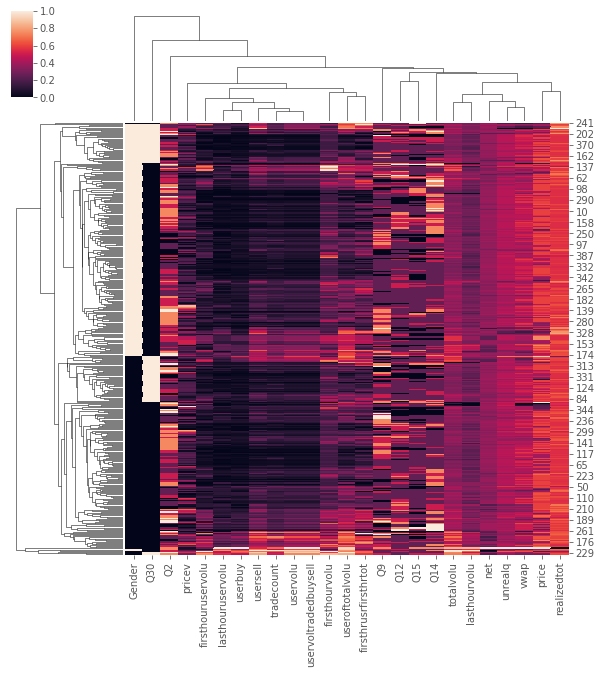

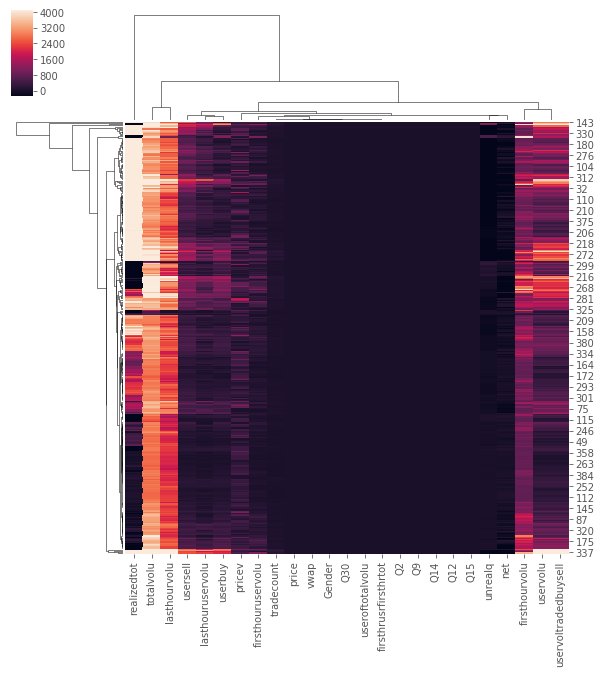

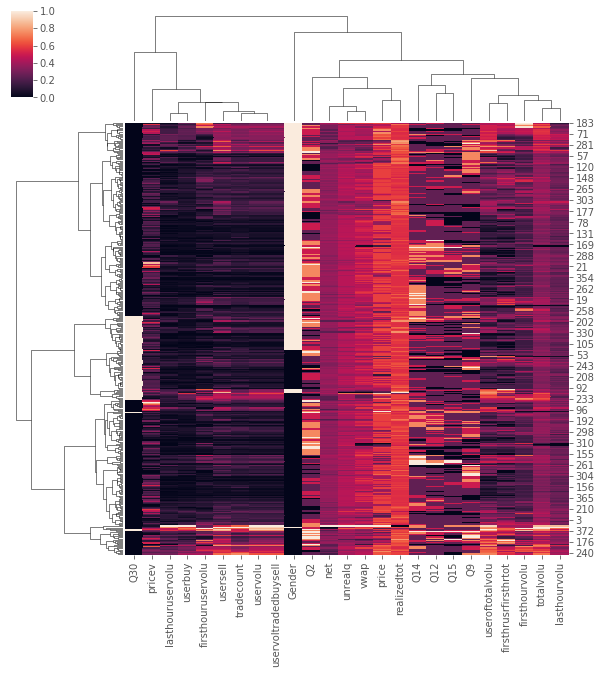

In [93]:
#sns.clustermap(cdata);

#sns.clustermap(cdata, z_score=0);

#sns.clustermap(cdata, col_cluster=False);



# y axis = row number
# x axis = column

sns.clustermap(cdata, standard_scale=1);



sns.clustermap(cdata, robust=True);
# you can see that realizedtot and unrealq are on opposite ends of the colormap in the upper range; nearly perfect negative correlation as indicated earlier
# lasthourvolu seems to be consistently greater than firsthourvolu



sns.clustermap(cdata, metric="euclidean", standard_scale=1, method="ward", robust=True);

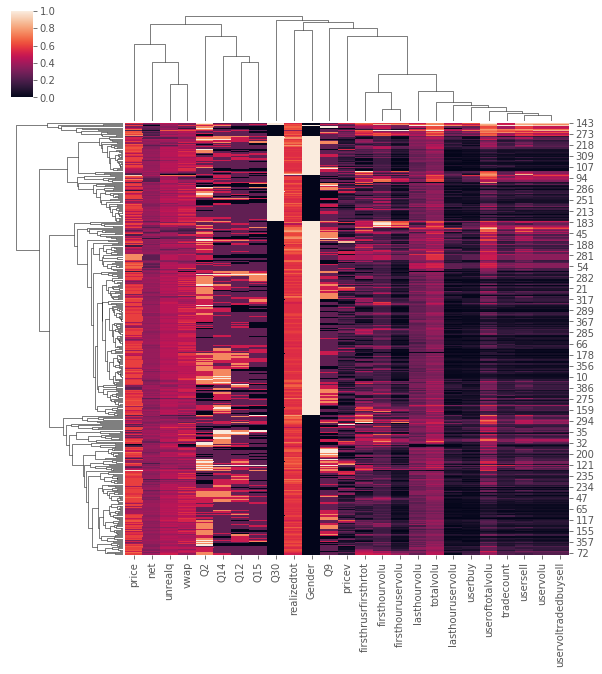

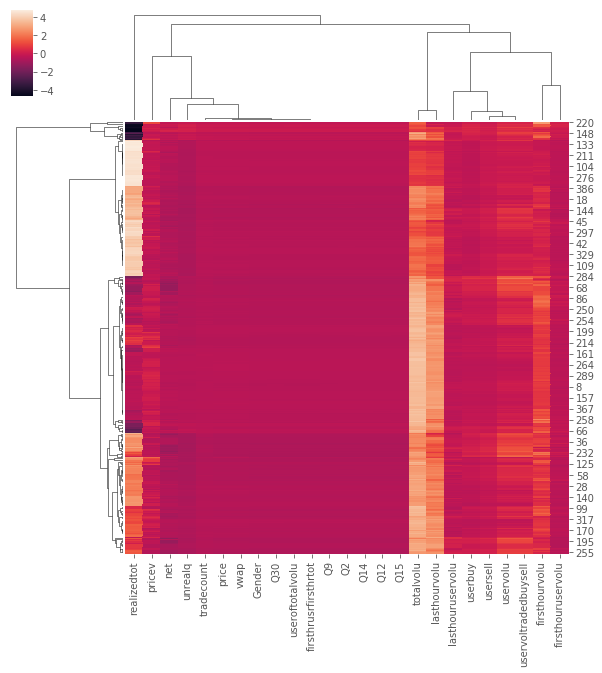

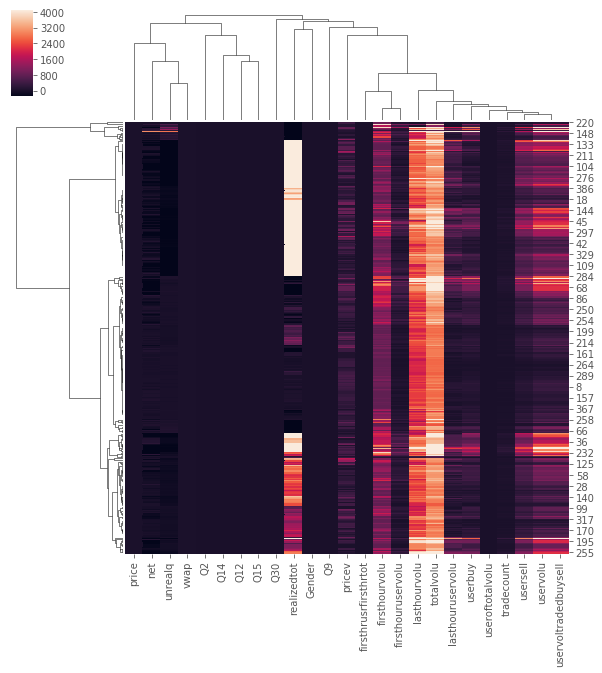

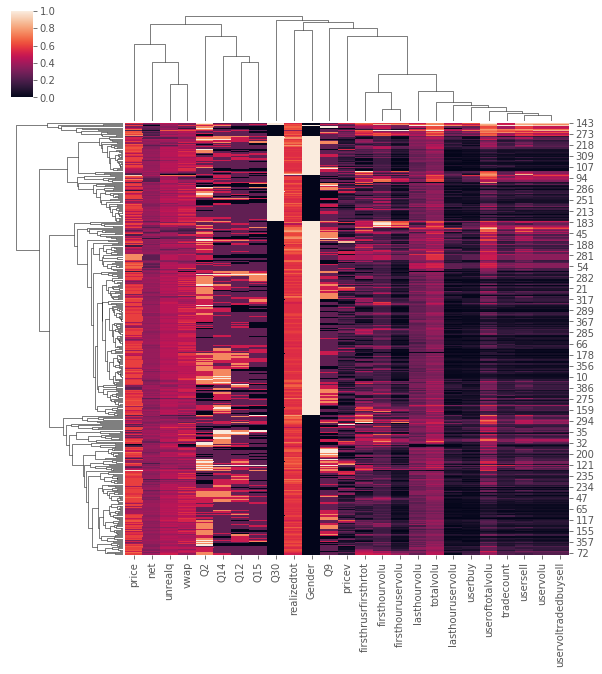

In [94]:
#sns.clustermap(cdata, metric="correlation");

sns.clustermap(cdata, metric="correlation", standard_scale=1);

sns.clustermap(cdata, metric="correlation",z_score=0);

#sns.clustermap(cdata, metric="correlation",col_cluster=False);

sns.clustermap(cdata, metric="correlation",robust=True);

sns.clustermap(cdata, metric="correlation", standard_scale=1, method="average", robust=True);

## Dendrogram

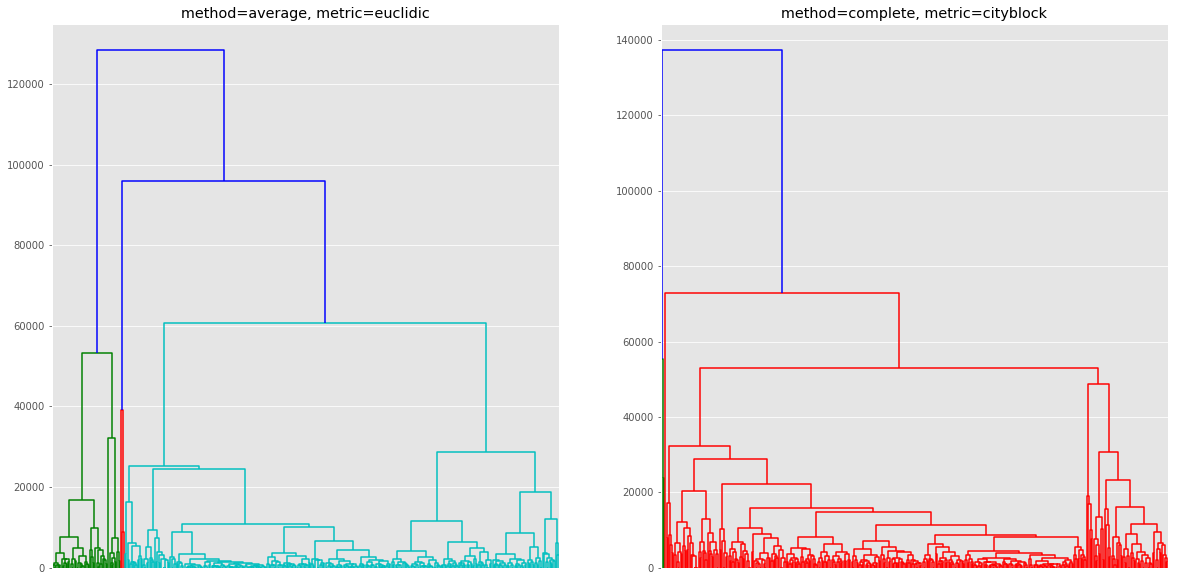

In [95]:
d1 = linkage(cdata, method='ward', metric='euclidean')
d2 = linkage(cdata, method='complete', metric='cityblock')

plt.figure(figsize=(20,10))

plt1 = plt.subplot(1,2,1)
plt.title("method=average, metric=euclidic")
dendrogram(d1)
plt1.set_xticks([])

plt2 = plt.subplot(1,2,2)
plt.title("method=complete, metric=cityblock")
dendrogram(d2)
plt2.set_xticks([])

plt.show();

# shows relationships 

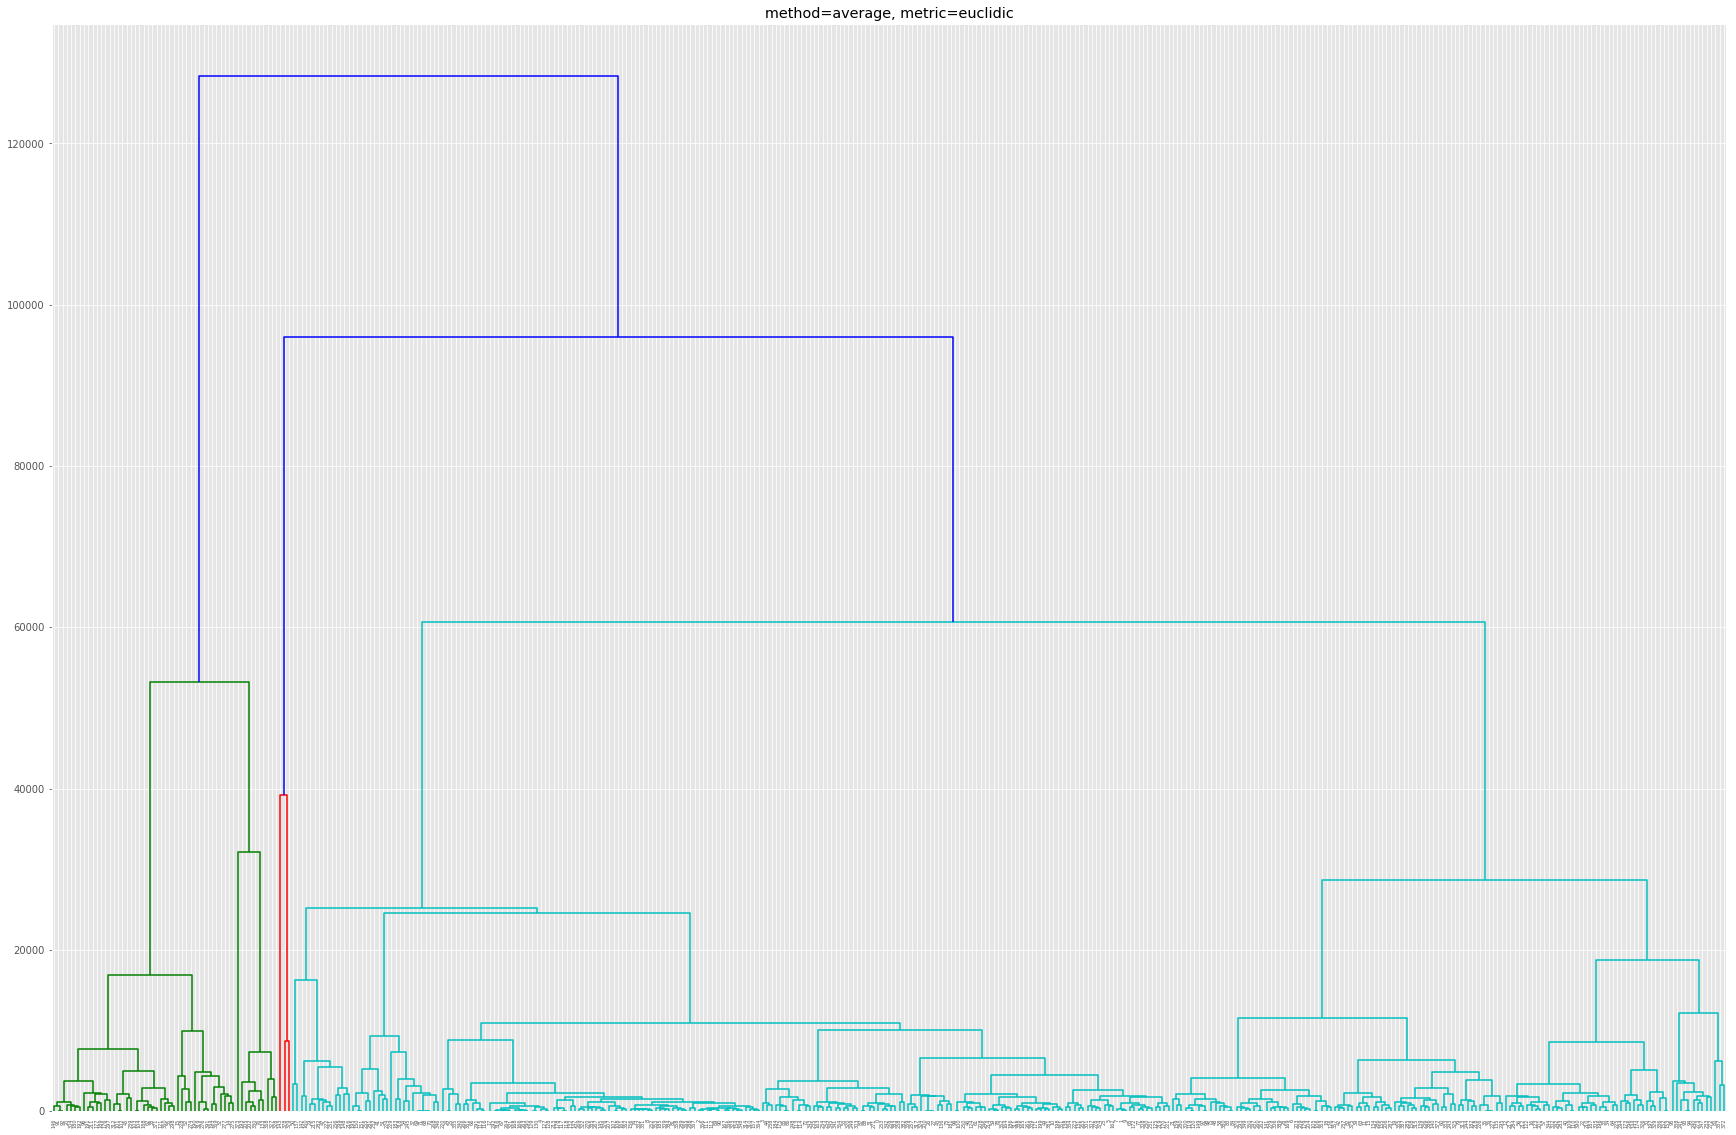

In [96]:
# enlarging dendrogram

plt.figure(figsize=(30,20))

plt.title("method=average, metric=euclidic")
dendrogram(d1)
plt1.set_xticks([]);
#plt.savefig('den');

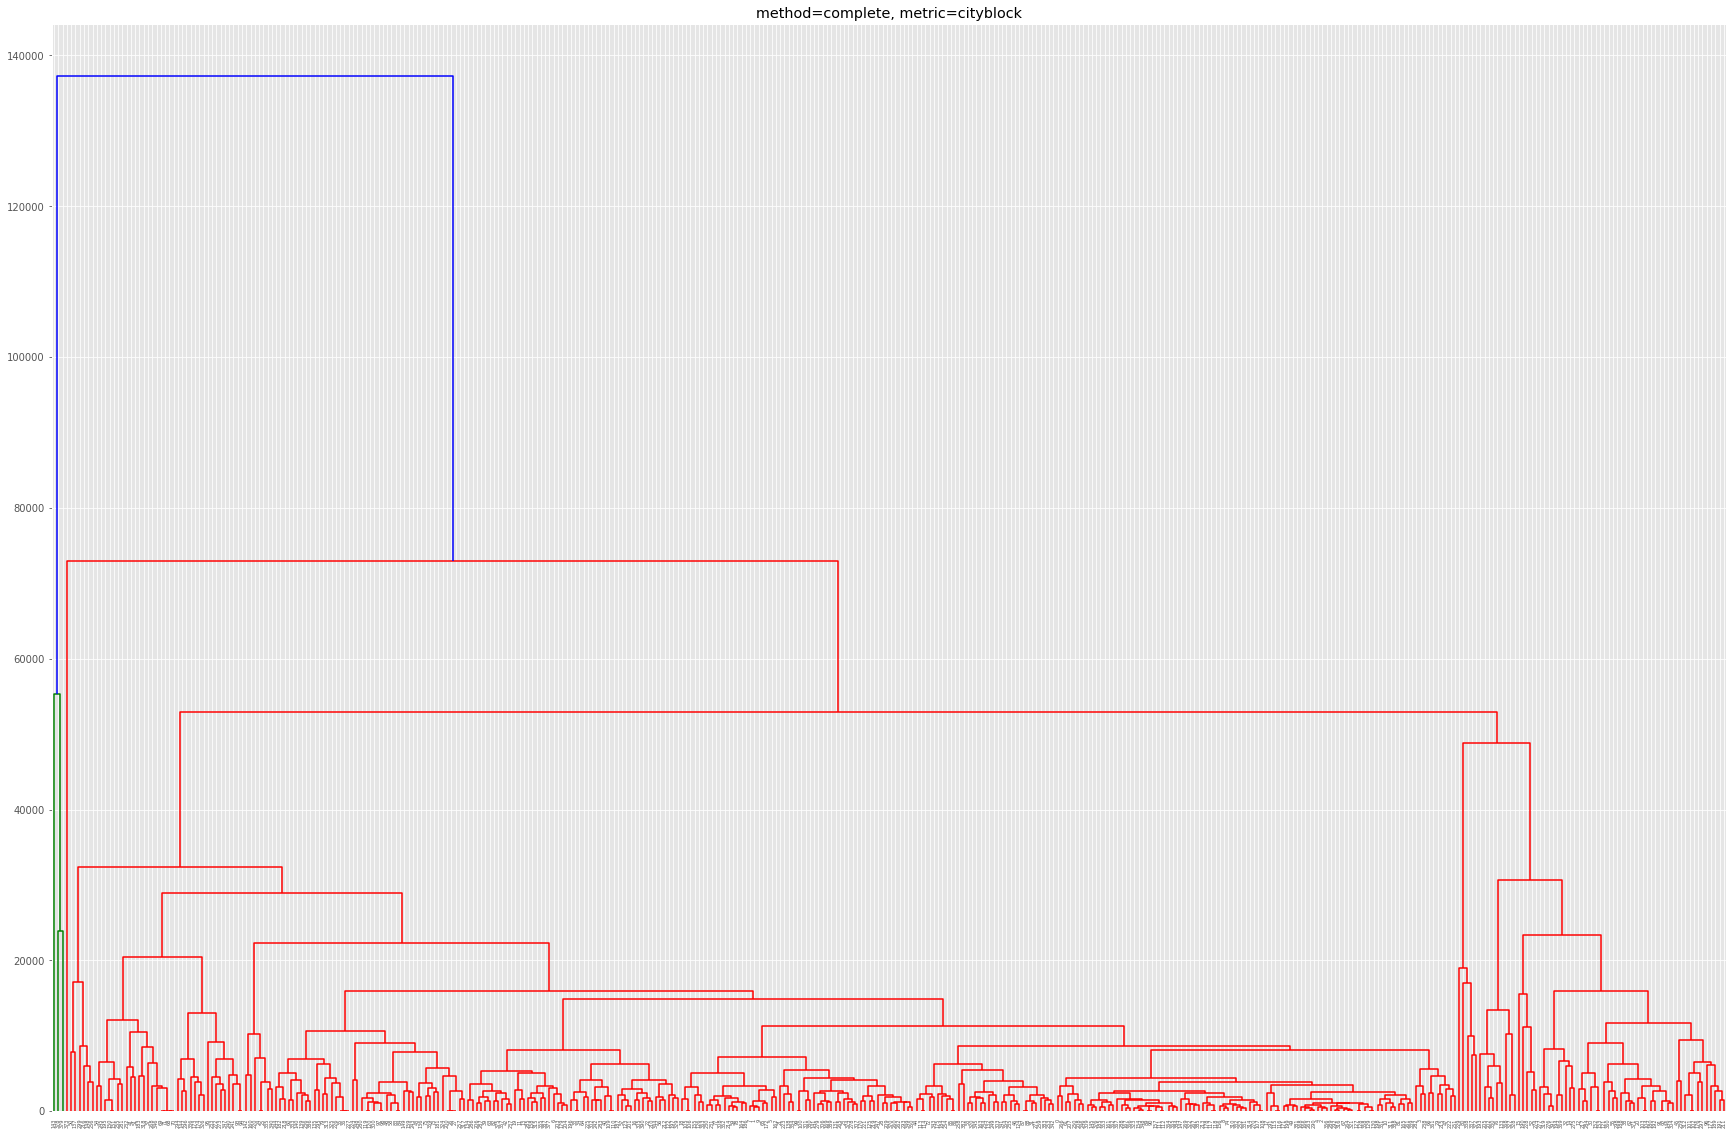

In [97]:
# enlarging dendrogram

plt.figure(figsize=(30,20))

plt.title("method=complete, metric=cityblock")
dendrogram(d2)
plt2.set_xticks([]);

## Clustering

### Finding number of clusters to use

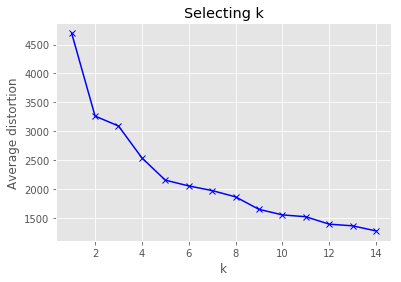

In [98]:
clusters=range(1,15)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(cdata)
    prediction=model.predict(cdata)
    meanDistortions.append(sum(np.min(cdist(cdata, model.cluster_centers_, 'euclidean'), axis=1)) / cdata.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k');



# 2 and 5 clusters seem to be the most obvious to try based on where an "elbow" may exist

### Clustering with n=5

In [99]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 25 columns):
price                   392 non-null float64
realizedtot             392 non-null float64
unrealq                 392 non-null int64
uservolu                392 non-null int64
useroftotalvolu         392 non-null float64
totalvolu               392 non-null int64
tradecount              392 non-null int64
firsthourvolu           392 non-null int64
firsthouruservolu       392 non-null int64
lasthourvolu            392 non-null int64
lasthouruservolu        392 non-null int64
firsthrusrfirsthrtot    392 non-null float64
vwap                    392 non-null float64
pricev                  392 non-null float64
net                     392 non-null float64
userbuy                 392 non-null int64
usersell                392 non-null int64
uservoltradedbuysell    392 non-null int64
Gender                  392 non-null int32
Q2                      392 non-null int32
Q9                   

### Agglomerative Clustering

In [100]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
x = cluster.fit_predict(cdata)
print(x)
np.bincount(x)

# agglomerative clustering with parameters
# also included is a count of the number of items in each cluster, for a total of 392 items
# most of the items are in clusters 1 and 3, 130 and 206 items respectively
# only 3 items exist in cluster 0, and 10 items in cluster 2
# cluster 4 has 43 items

[3 3 3 3 3 3 1 3 3 3 3 1 1 1 4 4 1 3 1 1 4 1 1 3 3 3 3 3 1 3 1 3 4 1 1 1 1
 3 4 1 1 3 1 3 3 4 3 3 1 3 3 3 4 3 3 4 1 1 1 3 1 3 4 1 1 3 3 3 3 3 3 3 3 3
 3 1 2 3 3 1 1 3 1 1 1 3 3 3 3 3 3 4 4 1 1 1 4 1 1 3 3 4 4 4 4 1 1 3 3 1 1
 3 3 3 3 3 3 3 3 1 1 4 1 1 3 3 1 3 3 3 3 3 3 2 1 1 3 3 3 1 1 1 3 0 1 3 4 3
 3 1 3 3 1 1 3 1 3 3 1 1 3 3 3 3 3 3 3 3 3 1 3 3 3 1 1 3 4 4 3 1 4 3 1 3 3
 3 3 1 4 4 4 4 4 2 4 3 1 1 3 3 3 1 2 1 1 2 1 3 3 1 1 4 1 3 3 3 3 1 1 3 3 3
 3 3 3 1 1 1 4 3 3 3 3 1 3 3 1 1 3 4 1 1 1 1 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3
 3 1 3 1 3 3 3 3 3 3 3 3 3 1 1 4 4 4 4 3 1 1 3 3 1 1 1 1 1 3 3 3 3 3 1 1 1
 1 4 4 3 1 3 1 3 4 1 1 3 3 3 3 3 4 1 3 1 3 3 3 4 3 3 3 3 3 1 1 2 2 1 2 3 3
 1 3 3 1 1 1 3 3 3 3 3 1 3 3 1 3 1 1 3 3 3 3 1 3 1 3 3 4 3 3 1 3 3 3 3 2 4
 1 4 1 2 3 1 3 1 0 0 1 3 3 3 3 3 1 1 3 1 1 4]


array([  3, 130,  10, 206,  43], dtype=int64)

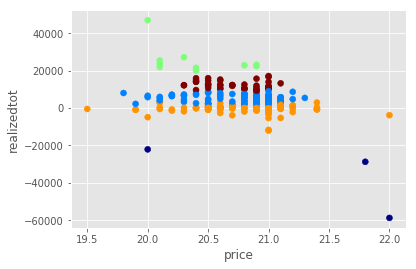

In [101]:
# cluster of price and realizedtot
plt.scatter(cdata.values[:,0],cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("price");
plt.ylabel("realizedtot");

# the following plots are scatterplots with color coded data points corresponding to the clusters in which they belong
# it can be noted that 3 points exist on the bottom half of the figure, corresponding to the 3 items present in cluster 0
# the same applies for the top points, of which there are 10 and thus correspond with the 10 itmes present in cluster 2

# this trend follows throughout the rest of these figures
# the figures each depict two different variables compared (price, realizedtot, unrealq, etc.)

#each of the figures shows easily recognizable clusters, particularly clusters 0 and 2

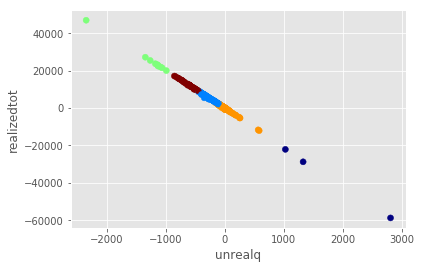

In [102]:
# cluster of unrealq and realizedtot
plt.scatter(cdata.values[:,2],cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("unrealq");
plt.ylabel("realizedtot");

# nearly perfect negative correlation

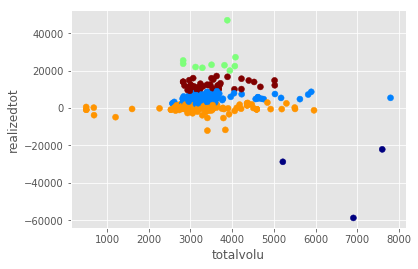

In [103]:
# cluster of totalvolu and realizedtot
plt.scatter(cdata.values[:,5],cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("totalvolu");
plt.ylabel("realizedtot");

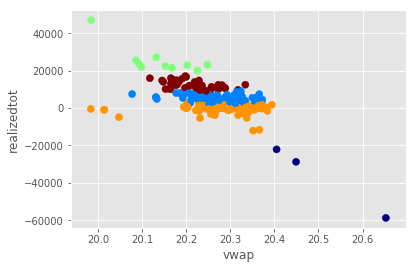

In [104]:
# cluster of vwap and realizedtot
plt.scatter(cdata.values[:,12], cdata.values[:,1], c=cluster.labels_, s=50, cmap='jet');
plt.xlabel("vwap");
plt.ylabel("realizedtot");

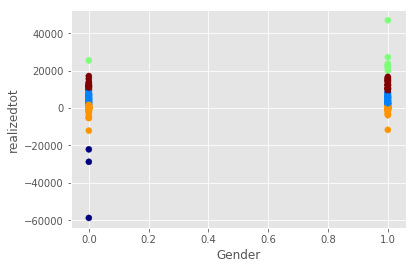

In [105]:
# cluster of Gender and realizedtot
plt.scatter(cdata.values[:,18], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Gender");
plt.ylabel("realizedtot");

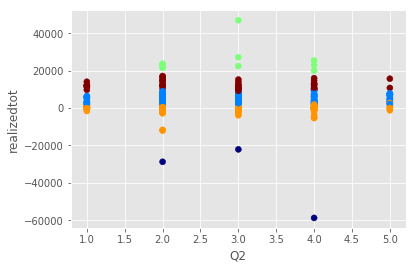

In [106]:
# cluster of Q2 and realizedtot
plt.scatter(cdata.values[:,19], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q2");
plt.ylabel("realizedtot");

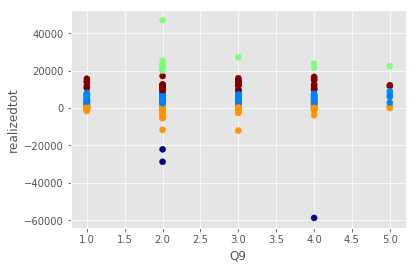

In [107]:
# cluster of Q9 and realizedtot
plt.scatter(cdata.values[:,20], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q9");
plt.ylabel("realizedtot");

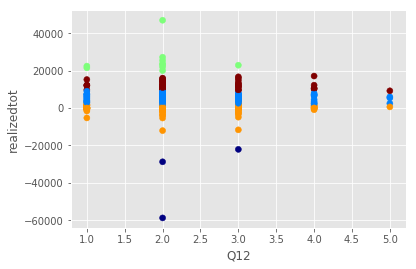

In [108]:
# cluster of Q12 and realizedtot
plt.scatter(cdata.values[:,21], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q12");
plt.ylabel("realizedtot");

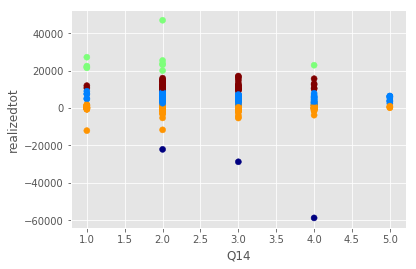

In [109]:
# cluster of Q14 and realizedtot
plt.scatter(cdata.values[:,22], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q14");
plt.ylabel("realizedtot");

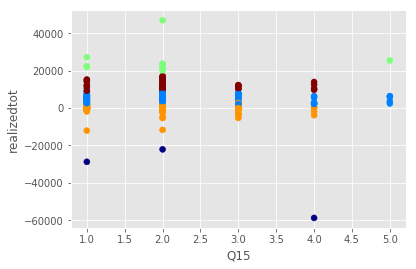

In [110]:
# cluster of Q15 and realizedtot
plt.scatter(cdata.values[:,23], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q15");
plt.ylabel("realizedtot");

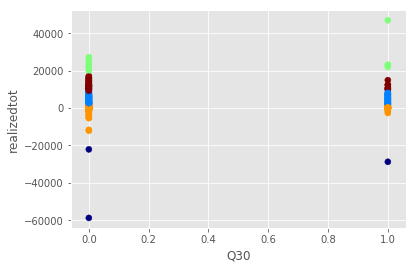

In [111]:
# cluster of Q30 and realizedtot
plt.scatter(cdata.values[:,24], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q30");
plt.ylabel("realizedtot");

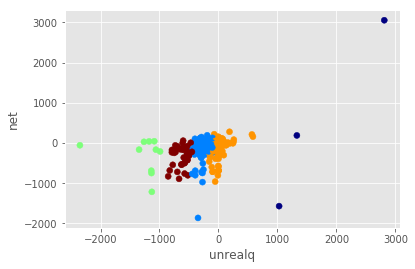

In [112]:
# cluster of unrealq and net
plt.scatter(cdata.values[:,2],cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("unrealq");
plt.ylabel("net");

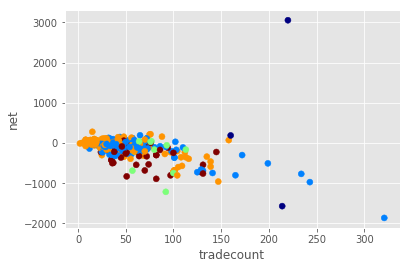

In [113]:
# cluster of tradecount and net
plt.scatter(cdata.values[:,6],cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("tradecount");
plt.ylabel("net");

# here, the clusters begin to overlap more severely
# the clear delineations between clusters are gone

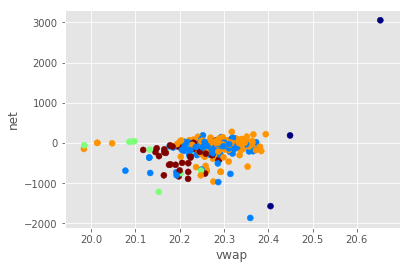

In [114]:
# cluster of vwap and net
plt.scatter(cdata.values[:,12], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("vwap");
plt.ylabel("net");

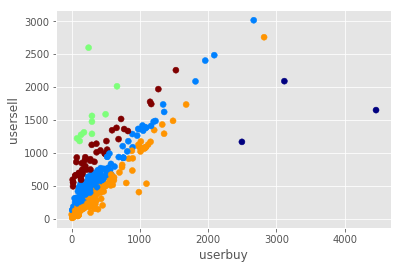

In [115]:
# cluster of userbuy and usersell
plt.scatter(cdata.values[:,15],cdata.values[:,16], c=cluster.labels_, cmap='jet');
plt.xlabel("userbuy");
plt.ylabel("usersell");

# again, we see easily recognizable clustering patterns

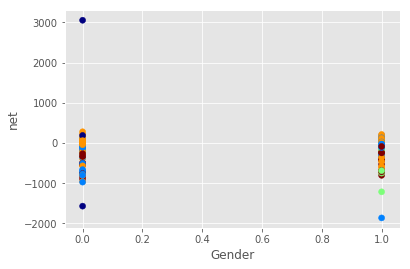

In [116]:
# cluster of gender and net
plt.scatter(cdata.values[:,18], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Gender");
plt.ylabel("net");

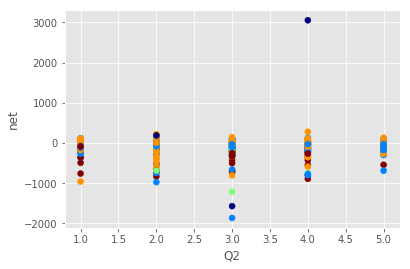

In [117]:
# cluster of Q2 and net
plt.scatter(cdata.values[:,19], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q2");
plt.ylabel("net");

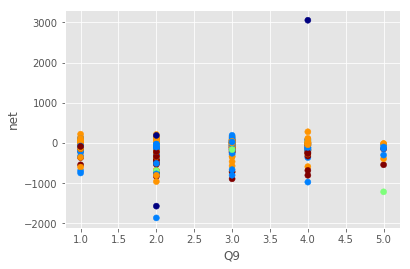

In [118]:
# cluster of Q9 and net
plt.scatter(cdata.values[:,20], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q9");
plt.ylabel("net");

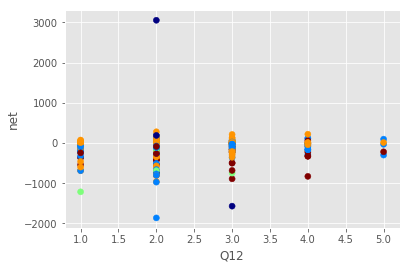

In [119]:
# cluster of Q12 and net
plt.scatter(cdata.values[:,21], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q12");
plt.ylabel("net");

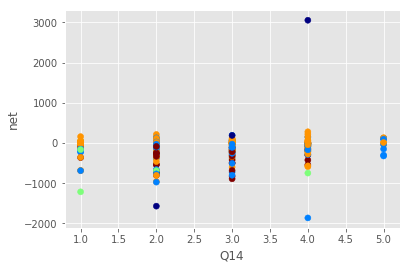

In [120]:
# cluster of Q14 and net
plt.scatter(cdata.values[:,22], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q14");
plt.ylabel("net");

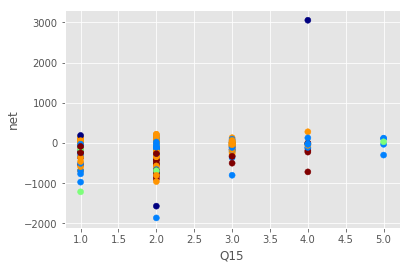

In [121]:
# cluster of Q15 and net
plt.scatter(cdata.values[:,23], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q15");
plt.ylabel("net");

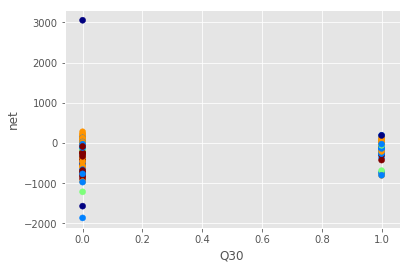

In [122]:
# cluster of Q30 and net
plt.scatter(cdata.values[:,24], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q30");
plt.ylabel("net");

### Kmeans Clustering

In [123]:
kmeans = KMeans(n_clusters=5, max_iter=1000, init='k-means++', n_init=1000, algorithm = 'auto')
kmeans.fit(cdata)
print(kmeans.cluster_centers_)

y = kmeans.fit_predict(cdata);

# iterations and number of runs are set high so the model converges rather than hits an artificial limit

[[ 2.07377778e+01  1.21908135e+04 -6.03355556e+02  1.44077778e+03
   3.84498800e-01  3.54900000e+03  6.71777778e+01  1.25124444e+03
   2.47266667e+02  2.85791111e+03  6.21977778e+02  1.68401800e-01
   2.02259113e+01  4.02006668e+02 -3.14079879e+02  4.18711111e+02
   1.02206667e+03  1.44077778e+03  5.11111111e-01  2.80000000e+00
   2.75555556e+00  2.40000000e+00  2.48888889e+00  2.08888889e+00
   1.55555556e-01]
 [ 2.08568376e+01  2.82139322e+02 -1.64230769e+01  6.71568376e+02
   2.02200739e-01  3.07354701e+03  3.70085470e+01  1.18946154e+03
   1.68341880e+02  2.31558120e+03  2.33598291e+02  1.21201735e-01
   2.02984602e+01  3.59659829e+02 -6.17568317e+01  3.27572650e+02
   3.43995726e+02  6.71568376e+02  5.76923077e-01  2.76068376e+00
   2.31196581e+00  2.22222222e+00  2.57264957e+00  2.01282051e+00
   1.96581197e-01]
 [ 2.12666667e+01 -3.65680334e+04  1.72266667e+03  4.99000000e+03
   7.56687333e-01  6.57533333e+03  1.98000000e+02  2.14066667e+03
   6.55000000e+02  5.53600000e+03  2.3

#### Price and Realizedtot

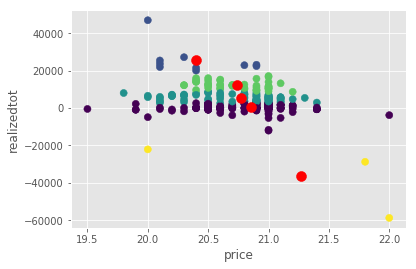

In [124]:
plt.scatter(cdata.values[:,0], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=100);
plt.xlabel("price");
plt.ylabel("realizedtot");

# these are largely the same scatterplots as before, except with added centroids for the clusters
# you can see that the centroids are, for the most part, central to their clusters
# cluster 0 with 3 items has few items spread far, equating to a centroid that is central of the points but not necessarily close to any

#### Unrealq and Realizedtot

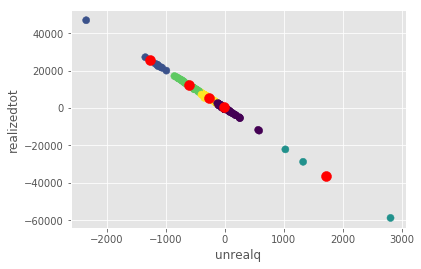

In [85]:
plt.scatter(cdata.values[:,2], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,2], centers[:,1], c='red', s=100);
plt.xlabel("unrealq");
plt.ylabel("realizedtot");

# cluster 0 has the same trend here
# we can see cluster 2 centroid is near a majority of the items in cluster 2

#### Totalvolu and Realizedtot

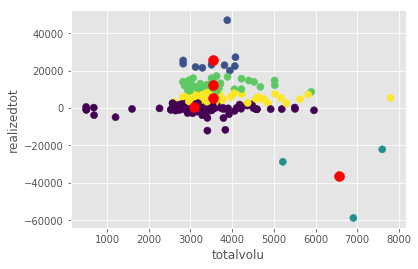

In [86]:
plt.scatter(cdata.values[:,5], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,5], centers[:,1], c='red', s=100);
plt.xlabel("totalvolu");
plt.ylabel("realizedtot");

# cluster 0 and 2, same trend
# blue cluster centroid possibly pulled left by several data points

#### Vwap and Realizedtot

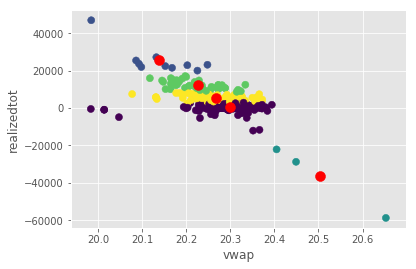

In [87]:
plt.scatter(cdata.values[:,12], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,12], centers[:,1], c='red', s=100);
plt.xlabel("vwap");
plt.ylabel("realizedtot");

#### Gender and realizedtot

In [88]:
plt.scatter(cdata.values[:,18], cdata.values[:,1],c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,18], centers[:,1], c='red', s=100);
plt.xlabel("Gender");
plt.ylabel("realizedtot");

IndexError: index 18 is out of bounds for axis 1 with size 18

#### Q2 and realizedtot

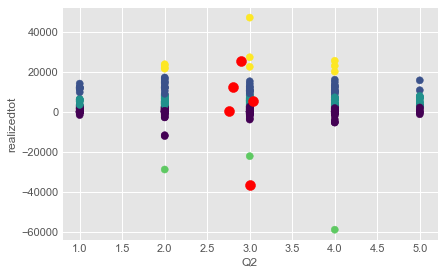

In [1688]:
plt.scatter(cdata.values[:,19], cdata.values[:,1],c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,19], centers[:,1], c='red', s=100);
plt.xlabel("Q2");
plt.ylabel("realizedtot");

#### Q9 and realizedtot

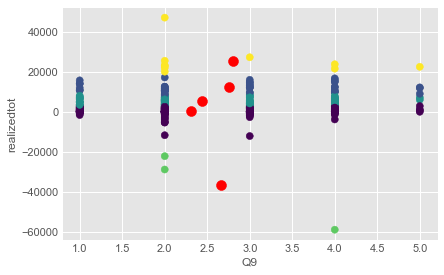

In [1689]:
plt.scatter(cdata.values[:,20], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,20], centers[:,1], c='red', s=100);
plt.xlabel("Q9");
plt.ylabel("realizedtot");

#### Q12 and realizedtot

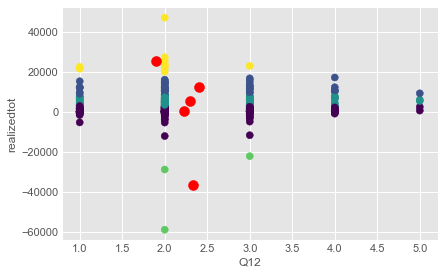

In [1690]:
plt.scatter(cdata.values[:,21], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,21], centers[:,1], c='red', s=100);
plt.xlabel("Q12");
plt.ylabel("realizedtot");

#### Q14 and realizedtot

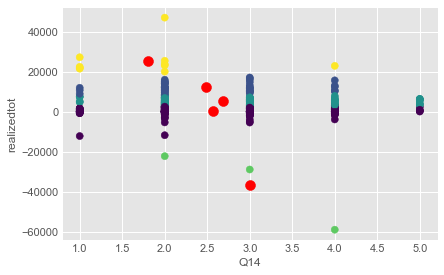

In [1691]:
plt.scatter(cdata.values[:,22], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,22], centers[:,1], c='red', s=100);
plt.xlabel("Q14");
plt.ylabel("realizedtot");

#### Q15 and realizedtot

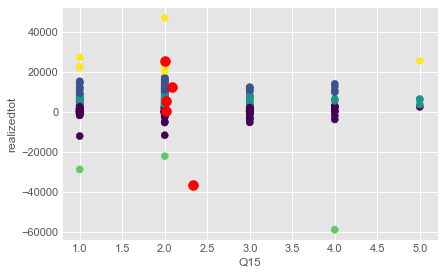

In [1692]:
plt.scatter(cdata.values[:,23], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,23], centers[:,1], c='red', s=100);
plt.xlabel("Q15");
plt.ylabel("realizedtot");

#### Q30 and realizedtot

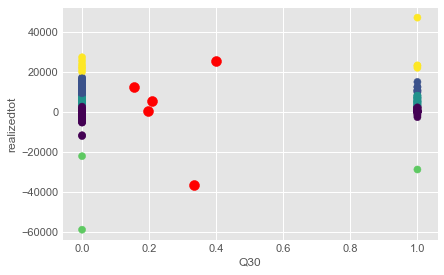

In [1693]:
plt.scatter(cdata.values[:,24], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,24], centers[:,1], c='red', s=100);
plt.xlabel("Q30");
plt.ylabel("realizedtot");

#### Unrealq and Net

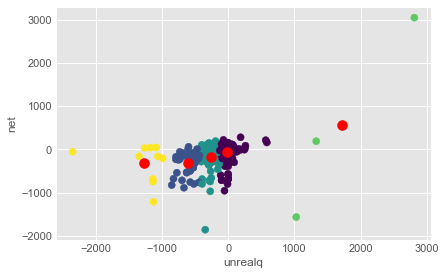

In [1694]:
plt.scatter(cdata.values[:,2], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,2], centers[:,14], c='red', s=100);
plt.xlabel("unrealq");
plt.ylabel("net");

# cluster 0 centroid far from two of the points

#### Tradecount and Net

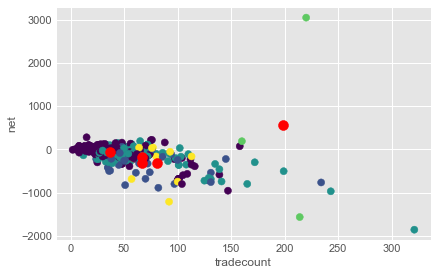

In [1695]:
plt.scatter(cdata.values[:,6], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,6], centers[:,14], c='red', s=100);
plt.xlabel("tradecount");
plt.ylabel("net");

# many of the clusters overlap

#### Vwap and Net

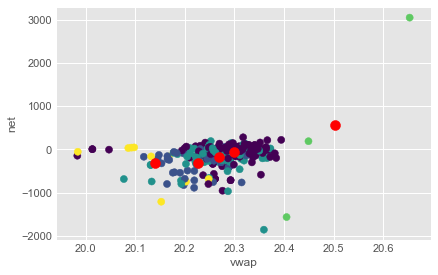

In [1696]:
plt.scatter(cdata.values[:,12], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,12], centers[:,14], c='red', s=100);
plt.xlabel("vwap");
plt.ylabel("net");

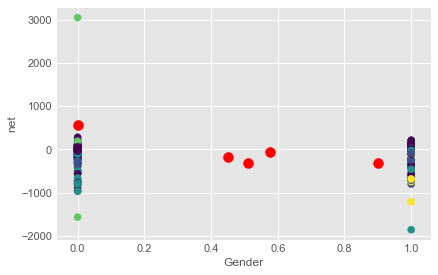

In [1697]:
plt.scatter(cdata.values[:,18], cdata.values[:,14],c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,18], centers[:,14], c='red', s=100);
plt.xlabel("Gender");
plt.ylabel("net");

#### Q2 and net

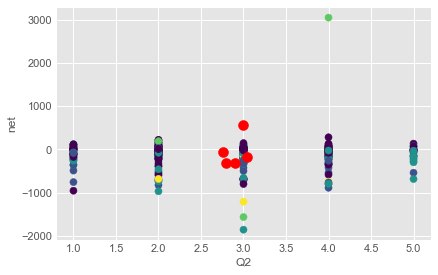

In [1698]:
plt.scatter(cdata.values[:,19], cdata.values[:,14],c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,19], centers[:,14], c='red', s=100);
plt.xlabel("Q2");
plt.ylabel("net");

#### Q9 and net

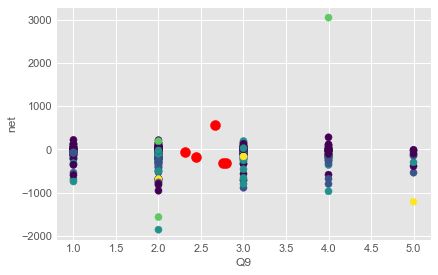

In [1699]:
plt.scatter(cdata.values[:,20], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,20], centers[:,14], c='red', s=100);
plt.xlabel("Q9");
plt.ylabel("net");

#### Q12 and net

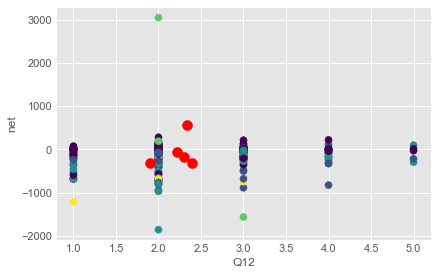

In [1700]:
plt.scatter(cdata.values[:,21], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,21], centers[:,14], c='red', s=100);
plt.xlabel("Q12");
plt.ylabel("net");

#### Q14 and net

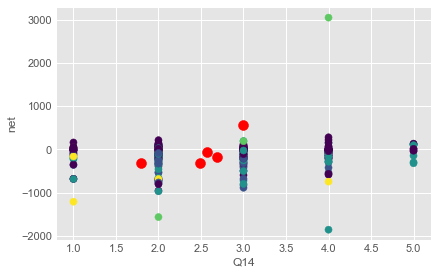

In [1701]:
plt.scatter(cdata.values[:,22], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,22], centers[:,14], c='red', s=100);
plt.xlabel("Q14");
plt.ylabel("net");

#### Q15 and net

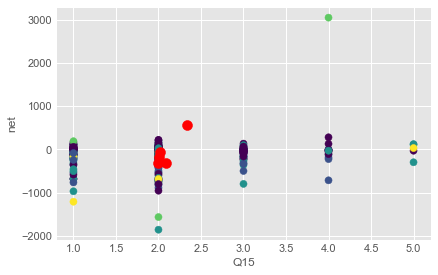

In [1702]:
plt.scatter(cdata.values[:,23], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,23], centers[:,14], c='red', s=100);
plt.xlabel("Q15");
plt.ylabel("net");

#### Q30 and net

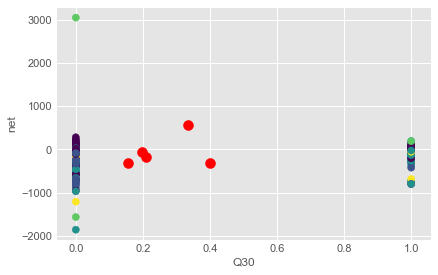

In [1703]:
plt.scatter(cdata.values[:,24], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,24], centers[:,14], c='red', s=100);
plt.xlabel("Q30");
plt.ylabel("net");

#### Userbuy and Usersell

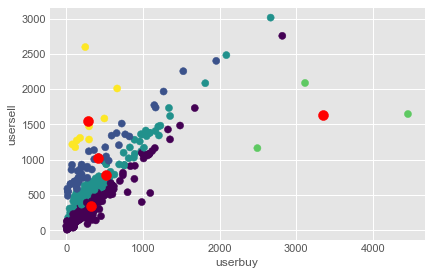

In [1704]:
plt.scatter(cdata.values[:,15], cdata.values[:,16], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,15], centers[:,16], c='red', s=100);
plt.xlabel("userbuy");
plt.ylabel("usersell");

### Clustering with n=2

In [1627]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 25 columns):
price                   392 non-null float64
realizedtot             392 non-null float64
unrealq                 392 non-null int64
uservolu                392 non-null int64
useroftotalvolu         392 non-null float64
totalvolu               392 non-null int64
tradecount              392 non-null int64
firsthourvolu           392 non-null int64
firsthouruservolu       392 non-null int64
lasthourvolu            392 non-null int64
lasthouruservolu        392 non-null int64
firsthrusrfirsthrtot    392 non-null float64
vwap                    392 non-null float64
pricev                  392 non-null float64
net                     392 non-null float64
userbuy                 392 non-null int64
usersell                392 non-null int64
uservoltradedbuysell    392 non-null int64
Gender                  392 non-null int32
Q2                      392 non-null int32
Q9                   

### Agglomerative Clustering

In [1628]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
x = cluster.fit_predict(cdata)
print(x)
np.bincount(x)

# changed the number of clusers to 2

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


array([339,  53], dtype=int64)

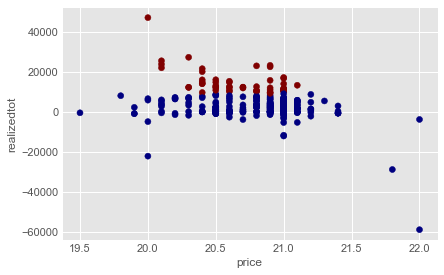

In [1629]:
# cluster of price and realizedtot
plt.scatter(cdata.values[:,0],cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("price");
plt.ylabel("realizedtot");

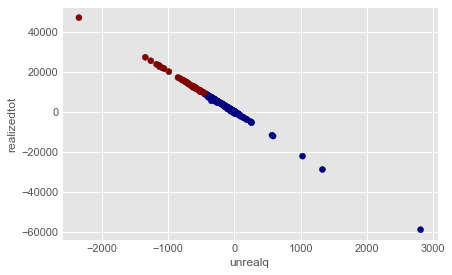

In [1630]:
# cluster of unrealq and realizedtot
plt.scatter(cdata.values[:,2],cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("unrealq");
plt.ylabel("realizedtot");

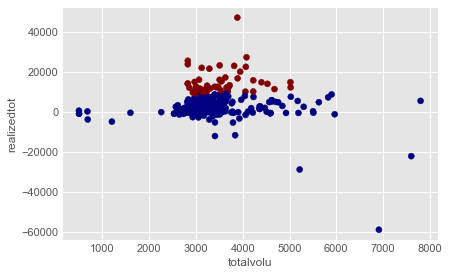

In [1631]:
# cluster of totalvolu and realizedtot
plt.scatter(cdata.values[:,5],cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("totalvolu");
plt.ylabel("realizedtot");

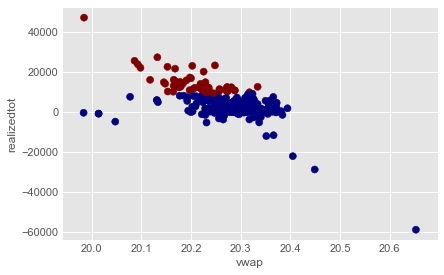

In [1632]:
# cluster of vwap and realizedtot
plt.scatter(cdata.values[:,12], cdata.values[:,1], c=cluster.labels_, s=50, cmap='jet');
plt.xlabel("vwap");
plt.ylabel("realizedtot");

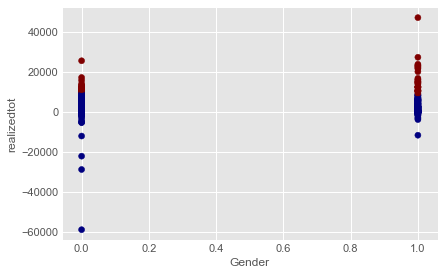

In [1633]:
# cluster of Gender and realizedtot
plt.scatter(cdata.values[:,18], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Gender");
plt.ylabel("realizedtot");

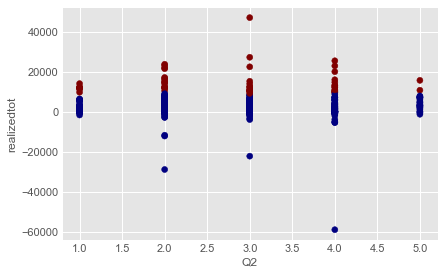

In [1634]:
# cluster of Q2 and realizedtot
plt.scatter(cdata.values[:,19], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q2");
plt.ylabel("realizedtot");

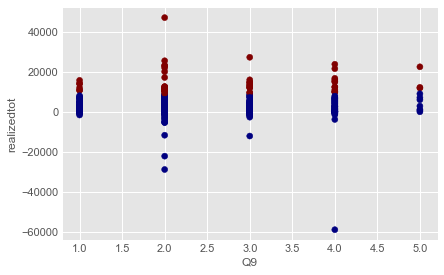

In [1635]:
# cluster of Q9 and realizedtot
plt.scatter(cdata.values[:,20], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q9");
plt.ylabel("realizedtot");

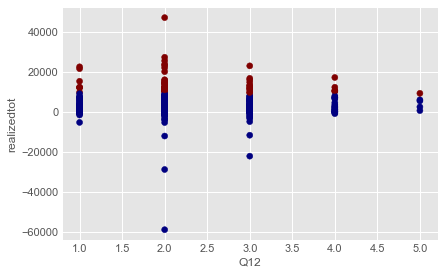

In [1636]:
# cluster of Q12 and realizedtot
plt.scatter(cdata.values[:,21], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q12");
plt.ylabel("realizedtot");

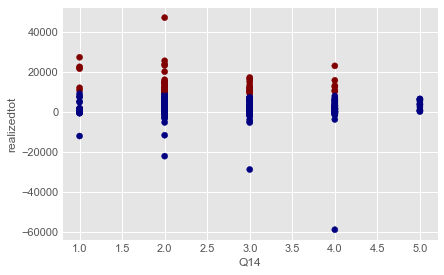

In [1637]:
# cluster of Q14 and realizedtot
plt.scatter(cdata.values[:,22], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q14");
plt.ylabel("realizedtot");

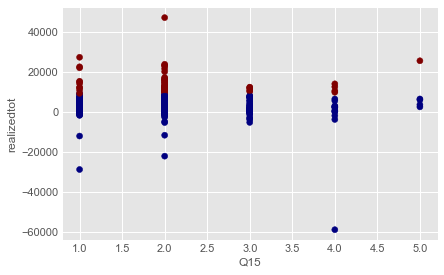

In [1638]:
# cluster of Q15 and realizedtot
plt.scatter(cdata.values[:,23], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q15");
plt.ylabel("realizedtot");

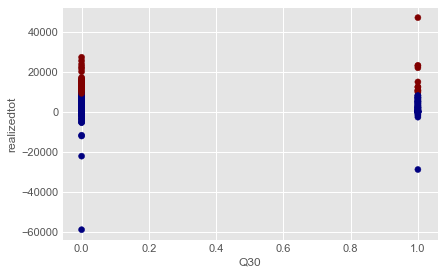

In [1639]:
# cluster of Q30 and realizedtot
plt.scatter(cdata.values[:,24], cdata.values[:,1], c=cluster.labels_, cmap='jet');
plt.xlabel("Q30");
plt.ylabel("realizedtot");

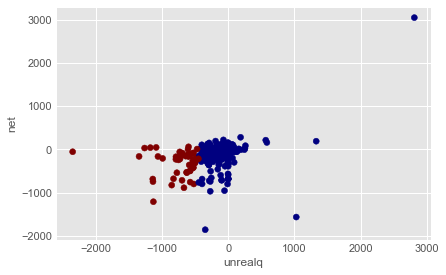

In [1640]:
# cluster of unrealq and net
plt.scatter(cdata.values[:,2],cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("unrealq");
plt.ylabel("net");

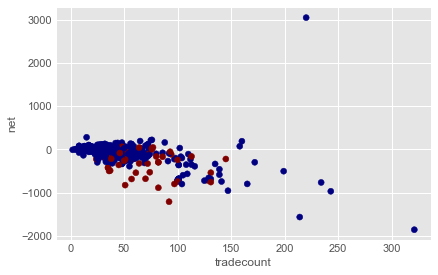

In [1641]:
# cluster of tradecount and net
plt.scatter(cdata.values[:,6],cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("tradecount");
plt.ylabel("net");

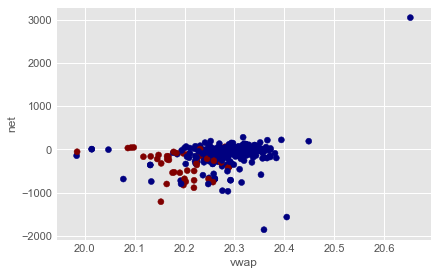

In [1642]:
# cluster of vwap and net
plt.scatter(cdata.values[:,12], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("vwap");
plt.ylabel("net");

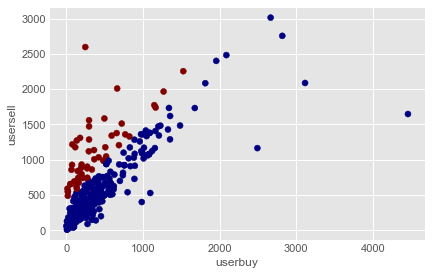

In [1643]:
# cluster of userbuy and usersell
plt.scatter(cdata.values[:,15],cdata.values[:,16], c=cluster.labels_, cmap='jet');
plt.xlabel("userbuy");
plt.ylabel("usersell");

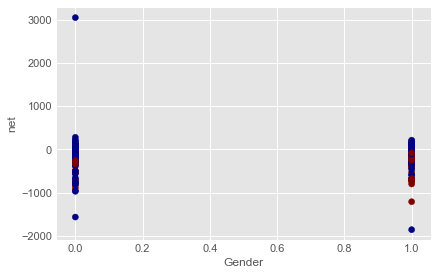

In [1644]:
# cluster of Gender and net
plt.scatter(cdata.values[:,18], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Gender");
plt.ylabel("net");

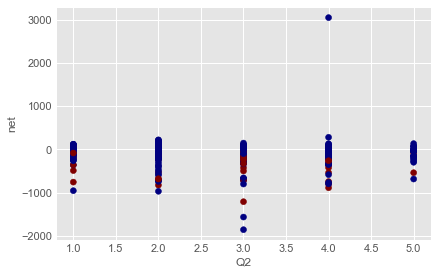

In [1645]:
# cluster of Q2 and net
plt.scatter(cdata.values[:,19], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q2");
plt.ylabel("net");

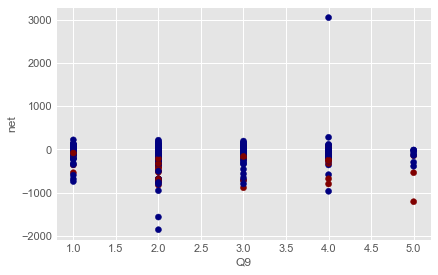

In [1646]:
# cluster of Q9 and net
plt.scatter(cdata.values[:,20], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q9");
plt.ylabel("net");

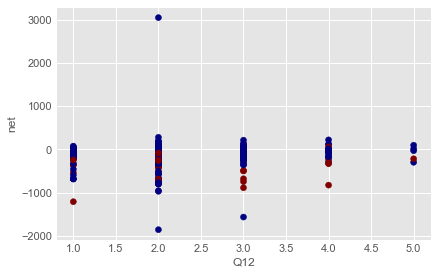

In [1647]:
# cluster of Q12 and net
plt.scatter(cdata.values[:,21], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q12");
plt.ylabel("net");

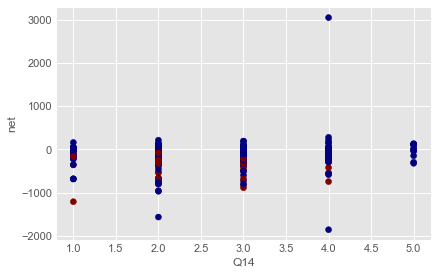

In [1648]:
# cluster of Q14 and net
plt.scatter(cdata.values[:,22], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q14");
plt.ylabel("net");

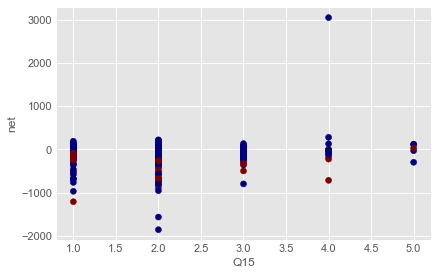

In [1649]:
# cluster of Q15 and net
plt.scatter(cdata.values[:,23], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q15");
plt.ylabel("net");

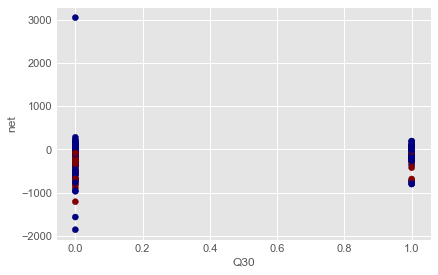

In [1650]:
# cluster of Q30 and net
plt.scatter(cdata.values[:,24], cdata.values[:,14], c=cluster.labels_, cmap='jet');
plt.xlabel("Q30");
plt.ylabel("net");

### Kmeans Clustering

In [1651]:
kmeans = KMeans(n_clusters=2, max_iter=1000, init='k-means++', n_init=1000, algorithm = 'auto')
kmeans.fit(cdata)
print(kmeans.cluster_centers_)

y = kmeans.fit_predict(cdata);

[[ 2.08449231e+01  1.20456740e+03 -6.24707692e+01  8.58113846e+02
   2.39719658e-01  3.22012615e+03  4.58800000e+01  1.22666462e+03
   1.94741538e+02  2.45577231e+03  3.20193846e+02  1.35302175e-01
   2.02940765e+01  3.72982769e+02 -8.34966004e+01  3.97821538e+02
   4.60292308e+02  8.58113846e+02  5.38461538e-01  2.83384615e+00
   2.35384615e+00  2.24923077e+00  2.62769231e+00  2.00923077e+00
   1.96923077e-01]
 [ 2.06552239e+01  1.34032061e+04 -6.64805970e+02  1.58411940e+03
   4.20815090e-01  3.59474627e+03  7.17761194e+01  1.26364179e+03
   2.68328358e+02  2.91868657e+03  6.88835821e+02  1.85177299e-01
   2.02109123e+01  4.53034330e+02 -2.93556628e+02  4.59656716e+02
   1.12446269e+03  1.58411940e+03  5.52238806e-01  2.88059701e+00
   2.68656716e+00  2.28358209e+00  2.32835821e+00  2.08955224e+00
   2.23880597e-01]]


#### Price and Realizedtot

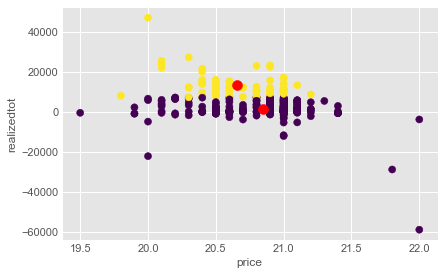

In [1652]:
plt.scatter(cdata.values[:,0], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=100);
plt.xlabel("price");
plt.ylabel("realizedtot");

# centroids very clear

#### Unrealq and Realizedtot

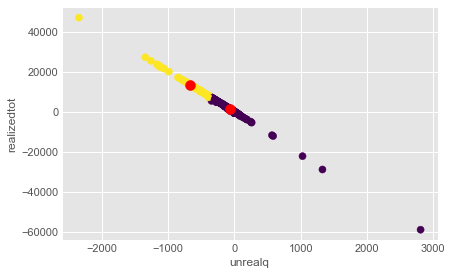

In [1653]:
plt.scatter(cdata.values[:,2], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,2], centers[:,1], c='red', s=100);
plt.xlabel("unrealq");
plt.ylabel("realizedtot");

#### Totalvolu and Realizedtot

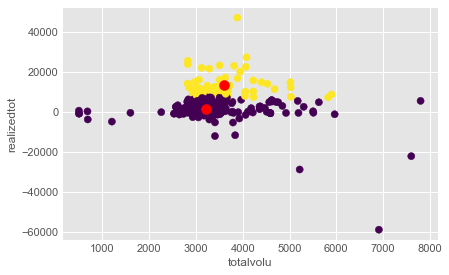

In [1654]:
plt.scatter(cdata.values[:,5], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,5], centers[:,1], c='red', s=100);
plt.xlabel("totalvolu");
plt.ylabel("realizedtot");

#### Vwap and Realizedtot

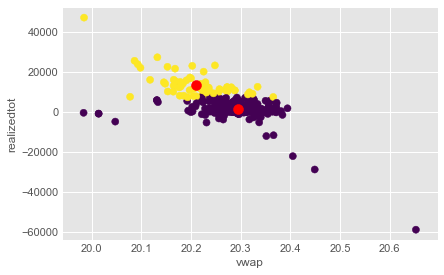

In [1655]:
plt.scatter(cdata.values[:,12], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,12], centers[:,1], c='red', s=100);
plt.xlabel("vwap");
plt.ylabel("realizedtot");

#### Gender and realizedtot

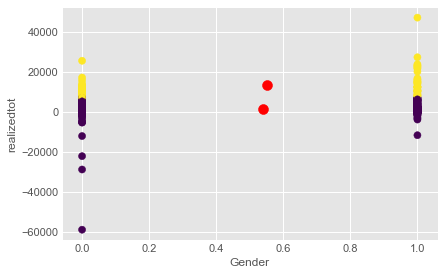

In [1656]:
plt.scatter(cdata.values[:,18], cdata.values[:,1],c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,18], centers[:,1], c='red', s=100);
plt.xlabel("Gender");
plt.ylabel("realizedtot");

#### Q2 and realizedtot

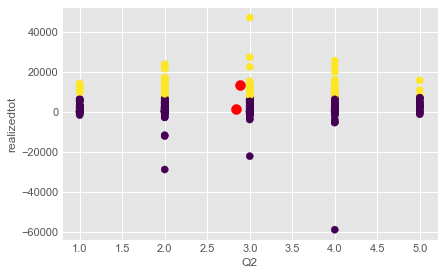

In [1657]:
plt.scatter(cdata.values[:,19], cdata.values[:,1],c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,19], centers[:,1], c='red', s=100);
plt.xlabel("Q2");
plt.ylabel("realizedtot");

#### Q9 and realizedtot

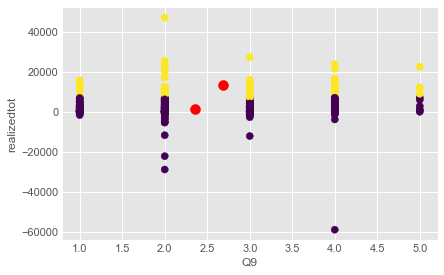

In [1658]:
plt.scatter(cdata.values[:,20], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,20], centers[:,1], c='red', s=100);
plt.xlabel("Q9");
plt.ylabel("realizedtot");

#### Q12 and realizedtot

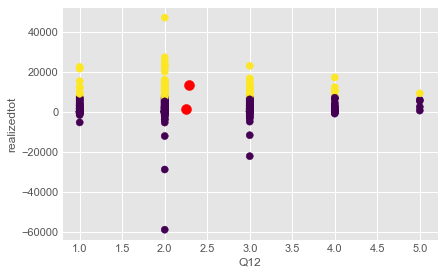

In [1659]:
plt.scatter(cdata.values[:,21], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,21], centers[:,1], c='red', s=100);
plt.xlabel("Q12");
plt.ylabel("realizedtot");

#### Q14 and realizedtot

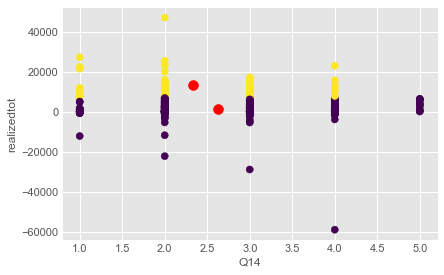

In [1660]:
plt.scatter(cdata.values[:,22], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,22], centers[:,1], c='red', s=100);
plt.xlabel("Q14");
plt.ylabel("realizedtot");

#### Q15 and realizedtot

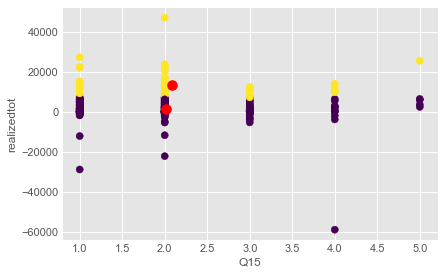

In [1661]:
plt.scatter(cdata.values[:,23], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,23], centers[:,1], c='red', s=100);
plt.xlabel("Q15");
plt.ylabel("realizedtot");

#### Q30 and realizedtot

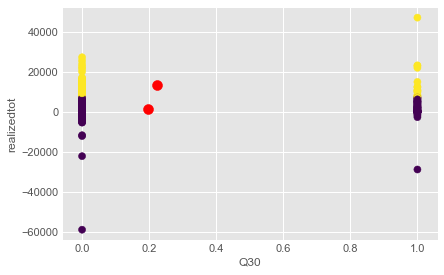

In [1662]:
plt.scatter(cdata.values[:,24], cdata.values[:,1], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,24], centers[:,1], c='red', s=100);
plt.xlabel("Q30");
plt.ylabel("realizedtot");

#### Unrealq and Net

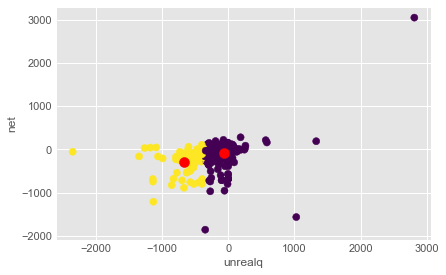

In [1663]:
plt.scatter(cdata.values[:,2], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,2], centers[:,14], c='red', s=100);
plt.xlabel("unrealq");
plt.ylabel("net");

#### Tradecount and Net

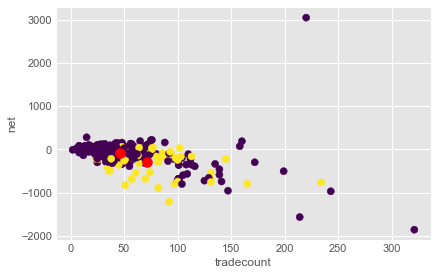

In [1664]:
plt.scatter(cdata.values[:,6], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,6], centers[:,14], c='red', s=100);
plt.xlabel("tradecount");
plt.ylabel("net");

#### Vwap and Net

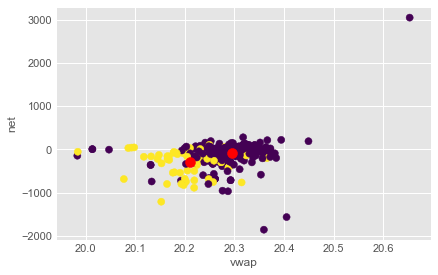

In [1665]:
plt.scatter(cdata.values[:,12], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,12], centers[:,14], c='red', s=100);
plt.xlabel("vwap");
plt.ylabel("net");

#### Gender and net

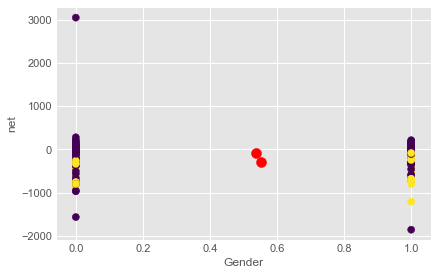

In [1666]:
plt.scatter(cdata.values[:,18], cdata.values[:,14],c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,18], centers[:,14], c='red', s=100);
plt.xlabel("Gender");
plt.ylabel("net");

#### Q2 and net

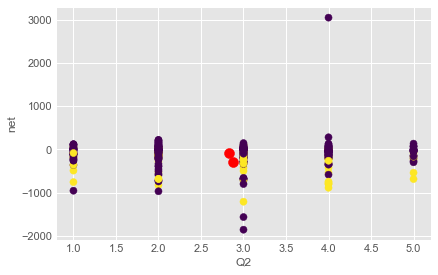

In [1667]:
plt.scatter(cdata.values[:,19], cdata.values[:,14],c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,19], centers[:,14], c='red', s=100);
plt.xlabel("Q2");
plt.ylabel("net");

#### Q9 and net

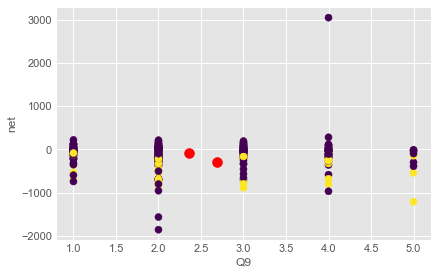

In [1668]:
plt.scatter(cdata.values[:,20], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,20], centers[:,14], c='red', s=100);
plt.xlabel("Q9");
plt.ylabel("net");

#### Q12 and net

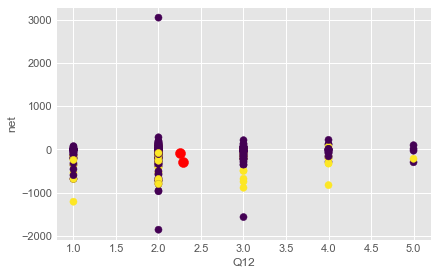

In [1669]:
plt.scatter(cdata.values[:,21], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,21], centers[:,14], c='red', s=100);
plt.xlabel("Q12");
plt.ylabel("net");

#### Q14 and net

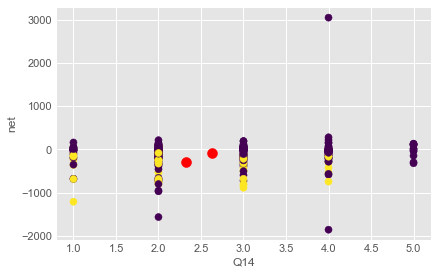

In [1670]:
plt.scatter(cdata.values[:,22], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,22], centers[:,14], c='red', s=100);
plt.xlabel("Q14");
plt.ylabel("net");

#### Q15 and net

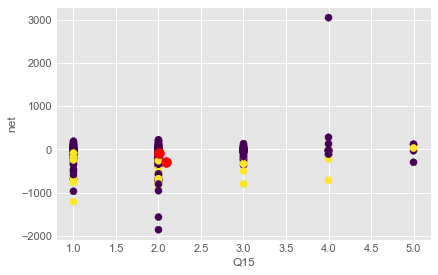

In [1671]:
plt.scatter(cdata.values[:,23], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,23], centers[:,14], c='red', s=100);
plt.xlabel("Q15");
plt.ylabel("net");

#### Q30 and net

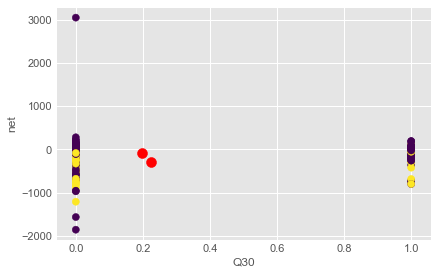

In [1672]:
plt.scatter(cdata.values[:,24], cdata.values[:,14], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,24], centers[:,14], c='red', s=100);
plt.xlabel("Q30");
plt.ylabel("net");

#### Userbuy and Usersell

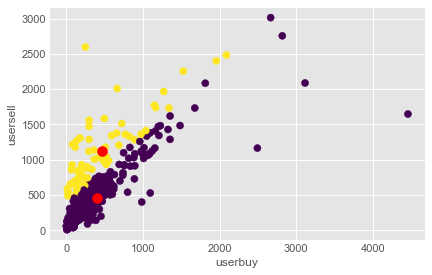

In [1673]:
plt.scatter(cdata.values[:,15], cdata.values[:,16], c=y, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:,15], centers[:,16], c='red', s=100);
plt.xlabel("userbuy");
plt.ylabel("usersell");

## Clustering with n=5 seems to offer the best clustering results
## n=2 does not offer enough clusters for the data